# Comparison of Forecasting Models for Thesis with the Title: 
##  *Assessing the Impact of Direct and Indirect Flexibilities on the Self-Consumption of an office Building: The Case of Predis-MHI, A Smart office Building


>***First time using a Jupyter Notebook ?*** In order to use this notebook online through the Mybinder public service, click the following icon  
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2FNanaKofi%2Fpredis_indirect_flexibility/master?labpath=Indirect_flex_assessment.ipynb)  

>You can then easily use this Jupyter notebook by runnning each cell with the Run ("Exécuter" in French) icon in the toolbar on top of the page. When the orange notebook icon in the tab turns into an hourglass, this means the code is still running. Do not hesitate to modify and adapt the code, working with Mybinder creates an online copy of the repository ipynb original file.
    

## Data specifications
>### Predis-MHI
|#|Key |Description |
|---|---|---|
| 1 | name |Predis_data_2020_2022.csv | 
| 2 | title |Predis-MHI electricity consumption and production datatsets | 
| 3 | id | |
| 4 | description |dataset containing the demand profiles <br> (building and 4 charging stations) and the solar PV (22kWp) production profiles <br>  collected from the Building Management System of GreEn-ER |
| 5 | language | en-US |
| 6 | subject |Reference the topic of the resource in ontology terms  |
| 7 | keywords |Smart Building, <br>Living Lab,<br>Building energy data] |
| 8 | publicationDate | (2023-07-17) |
| 9 | context |Used in a study to assess the impact of <br> indirect flexiblty on the perfrmance of a building's energy system  |
| 10 | spatial | France  | 
| 11 | temporal |2020-01-01 to 2022-12-31  |
| 12 | source |G2ELab |
| 13 | licenses |CC By 4.0  |
| 14 | contributors |Nana Kofi Twum-Duah, Frederic Wurtz, Stéphane Ploix, Manar Amayri |
| 15 | resources |individual file  |
| 16 | resolution |1 hour | 

>## Data sources
* GReEN-ER (Predis-MHI) energy data (EV charging data, building energy usage, PV production) available at (https://mhi-srv.g2elab.grenoble-inp.fr/grafana/d/Xl5OAbQGk/ve-borne-de-rechargement?orgId=3&from=now-1y&to=now).

>## Objectives
The goal is to implement and compare mainly three machine learning models for forecasting the demand and production profiles of the Predis-MHI platform.

For all intents and purposes, the diagram below represents the system being evaluated.

![green-er.png](../images/green-er.png)


## Relevant imports
to run this notebook, the following libraries are required:
* pandas Version => 1.2.4
* numpy Version => 1.19.5
* plotly Version => 4.14.1
* Pyomo Version => 5.7
* pvlib
* holidays
* pygam
* xgboost
* sklearn
* lightgbm

### Note
This note book will not run if you do not install the dependancies, you can do that in the next cell <br>
``os.system('pip install -e .')`` in the next cell is not required if you have already done this in terminal<br>
if you need to install the dependancies, uncomment the entire code block



### NOTE

The ``show_plots`` parameter is to allow for the plots to bre rendered in the GitLab repository (GitLab does not render html plots). If you want an interactive notebook set it to ``False`` and rerun the entire notebook.



Alternatively, an HTML version of this notebook is provided in the folder **html_files**

In [1]:
show_plots = True

## Import required libraries

In [2]:
import os

work_path = os.getcwd()
# ########################################################
# #uncomment to install dependencies
# print (work_path)
# os.chdir("../")


# work_path = os.getcwd()

# print (work_path)

# os.system('pip install -e .')

# os.chdir(f"{work_path}\notebooks")

# work_path = os.getcwd()

# print (work_path)
###################################################
###Necessary for glpk to  work on binder (if not on binder comment out next line)
# os.system('conda install -c conda-forge glpk')

In [3]:
from datetime import timedelta
import pandas as pd
import numpy as np
import holidays
import warnings
import pickle


import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
# import plotly.express as px

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics, model_selection
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.svm import SVR

from pygam import LinearGAM, s, f,l
import xgboost as xgb
import lightgbm as lgbm
import pvlib


from IPython.display import clear_output
from os import listdir

warnings.filterwarnings("ignore")

## Function Definition 

### 1. Solar PV Physical Model

In [4]:
# Physical Model for PV production based on PVLIB

def gen_sloar_pow(df =None, lattitude= 0, longitude = 0,  surface_tilt = 0, altitude = 330 ,azimuth = 30, nebulosity = False):


    df_ = df.copy()
    df_.index = pd.date_range(start="2022-01-01", periods = len(df_), freq="1H", tz="Europe/Paris").tz_localize(None)
    
    
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')


    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    module = sandia_modules['Schott_Solar_ASE_300_DGF_50__320___2007__E__']

    

    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    system = {'module': module, 'surface_azimuth': azimuth}



    solpos = pvlib.solarposition.get_solarposition(df_.index, lattitude, longitude)

    dni_extra = pvlib.irradiance.get_extra_radiation(df_.index)

    # print ("len", len(dni_extra))
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

    pressure = pvlib.atmosphere.alt2pres(altitude)

    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    df_["am_abs"] = am_abs
    tl = pvlib.clearsky.lookup_linke_turbidity(df_.index, lattitude, longitude)

    cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], df_["am_abs"], tl,  # altitude=altitude)
                                 dni_extra=dni_extra, altitude=altitude)

    aoi = pvlib.irradiance.aoi(surface_tilt, system['surface_azimuth'],
                               solpos['apparent_zenith'], solpos['azimuth'])

    total_irrad = pvlib.irradiance.get_total_irradiance(surface_tilt, system['surface_azimuth'],
                                                        solpos['apparent_zenith'],
                                                        solpos['azimuth'], cs['dni'], cs['ghi'], cs['dhi'],
                                                        dni_extra=dni_extra, model='haydavies')

    df_["total_irrad"] = total_irrad["poa_global"]
    df_["difuse_irrad"] = total_irrad["poa_diffuse"]
    df_["direct_irrad"] = total_irrad["poa_direct"]



    
    df_["aoi"] = aoi

    tcell = [pvlib.temperature.sapm_cell(df_["total_irrad"].iloc[i], df_["Temperature"].iloc[i], df_["wind_speed"].iloc[i], **temperature_model_parameters) for i
             in range(len(df_["total_irrad"]))]

    df_["cell_temp"] = tcell
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(df_["direct_irrad"], df_["difuse_irrad"],
                                                                    df_["am_abs"], df_["aoi"], module)
    df_["effective_irradiance"] = effective_irradiance
    
    
    if nebulosity:
        correction = []
        for irr, cloud in zip(effective_irradiance, df["cloudiness"]):
            #     print ("irr : {} and cloud : {}".format(irr,cloud))
            cloud /= 100
            correction.append((1 - 0.51 * cloud ** 6.42) * irr)

        df_["corrected_irradiation"] = correction
        prod_sim = pvlib.pvsystem.sapm(df_["corrected_irradiation"], df_["cell_temp"], module)
        
    else:
        prod_sim = pvlib.pvsystem.sapm(df_["effective_irradiance"], df_["cell_temp"], module)
    
    df_["PV_prod_pvlib"] = (prod_sim["p_mp"]/1000) * 22*3.33335
    
    df["PV_prod_pvlib"] = df_["PV_prod_pvlib"].tolist()
    return df_,df

>### 2. Prediction Error Evaluation Function
This function takes the predicted values, the ground truth, the desired evaluation metrics, and the number of days for which the evaluation metric should be evaluated as inputs and provides ass an output the value of the desired evaluation metric

In [5]:
def prediction_error (metric = "mean_absolute_error", period = 7 , df = None, predict = "prediction_1",perfect = "Measured"):
    tt = []
    d = {"r2_score" : "R²",
     "mean_absolute_error": "MAE",
     "mean_squared_error":"MSE"}
    for day in  df.resample(f"{period}D").mean().index:
        temp = df[df.index >= str(day.date())]
        
        temp = temp[temp.index < str(day + timedelta(days = period))]
        
        if metric == "mean_squared_error":
            error =  getattr(metrics, metric)(temp[perfect], temp[predict],squared = True)
            
        else : 
            
            error =  getattr(metrics, metric)(temp[perfect], temp[predict])
            
        tt.extend([error]*len(temp))
        #print (len(temp))
    name = f'{d[metric]}_[{predict}]'  
    df[name] = tt
    return  df

>### 3. Calendar Function
determines if the day ahead is a holiday and returns a binary vaue (1 if the day under consideration is a holiday or weekend) and 0 if its a normal working day (weekday)

In [6]:
def calendar(df,index = "datetime") :
    df = df.reset_index()
#     print(df)
    df['Year'] = df[index].dt.year
    df['Month_name'] = df[index].dt.month_name()
    df['Weekday'] = df[index].dt.day_name()
    df['Day_number'] = df[index].dt.day
    df['Hour'] = df[index].dt.hour
    df["week"] =  df[index].dt.isocalendar().week
    df["date"] =  df[index].dt.date

    df = df.set_index(index)

    df['is_holiday'] = 0
    df['is_weekend'] = 0

    ### Public Holidays
    fr = holidays.FR()

    # df.loc[df["date"] in  fr, 'calendar'] = 0
    for d, ind in zip(df["date"] , df.index) :

        if d in fr :
            df.loc[ind,"is_holiday"] = 1


    ### weekends
    df.loc[(df['Weekday'] == 'Saturday'), 'is_weekend'] = 1
    df.loc[(df['Weekday'] == 'Sunday'), 'is_weekend'] = 1

    ####COVID Lockdown:
    df.loc[(df['Month_name'] == "March") & (df["Day_number"] >= 16) & (df["Year"] == 2020), 'is_holiday'] = 1
    df.loc[(df['Month_name'] == "April") & (df["Year"] == 2020), 'is_holiday'] = 1
    df.loc[(df['Month_name'] == "May") & (df["Day_number"] <= 11) & (df["Year"] == 2020), 'is_holiday'] = 1
    df.loc[(df['Month_name'] == 'June') & (df['Year'] == 2020), 'is_holiday'] = 1
    df.loc[(df['Month_name'] == 'September') & (df['Year'] == 2020), 'is_holiday'] = 1
    
  
    
    df.loc[(df['week'] >=51 ) , 'is_holiday'] = 1
    df.loc[(df['Month_name'] == "July") & (df["Day_number"] == 31 ), 'is_holiday'] = 1
    df.loc[(df['Month_name'] == "August") & (df["Day_number"] <= 15), 'is_holiday'] = 1
       
    try:
        df.drop(columns=['Year',"date","week", 'Month_name', 'Weekday', 'Day_number', 'Hour', 'TMP'], inplace=True)

    except KeyError:
        df.drop(columns=['Year',"date", "week", 'Month_name', 'Weekday', 'Day_number', 'Hour'], inplace=True)

    return df

>### Reconstruction Function
for techniques that require multiple models (sequence to point), this function takes the individual predictions and returns a list with the full horizon of prediction

In [7]:
def reconstruct(results, prefix, horizon):
    new = []
    for i in range (len(results[f"{prefix}_0"])):
        
        for j in range(horizon) : 
            new.append(results[f"{prefix}_{j}"][i])
            
    return new

>### Reshape Function:
This function transforms the dataframe into the shape required by the ML models 

In [8]:
def reshape_ (df = None, horizon = 24,ref = "PV_production"):
 
    temp = {key  : [] for key in [col+f"_{i}" for col in df.columns  for i in range (horizon) ]}
    new_ind = []
    for col in df.columns:
        for index , frame in df[col].groupby([(df.index.month),(df.index.day),(df.index.year),df.index.hour]):
#             print (frame.values[0])
            temp[col+f"_{frame.index[0].hour}"].append(frame.values[0])
            
            if col == ref and frame.index[0].hour == 0 :
#                 frame.index[0].date
                new_ind.append (frame.index[0])
            else:
                pass
#                 print (frame.index)
    
        
#             break
            
#     print (new_ind , temp)
    return (pd.DataFrame(temp, index = new_ind).sort_index(axis=0,ascending=True))
#         df.loc[]

## Import Data and Visualise Data

> ### Read data from csv files

In [9]:
df = pd.read_csv("../data/predis_mhi_2015.csv",
                 sep = ",", decimal = ".",parse_dates = True , index_col = 'Datetime')
df.fillna(0, inplace = True)
############################################
#          Consumption data                #
############################################
df["consumption_lag_7_days"] =  df.Consumption.shift(24 * 7)
df["consumption_lag_1_day"] =  df.Consumption.shift(24)
# df["consumption_lead_1_day"] =  df.Consumption.shift(-24)
df["day_of_year"] = df.index.dayofyear



############################################
#             Production data              #
############################################

df["production_lag_1_day"]  = df.production.shift(24 * 1)
df["Temperature_lag_1_day"]  = df.Temperature.shift(24 *1 )

df["production_lag_1_day"]  = df.production.shift(24 * 1)
df["Temperature_lag_1_day"]  = df.Temperature.shift(24 *1 )


############################################
#             Weather data              #
############################################


data_directory="../data/weather_data"
filepaths = [f for f in listdir(data_directory) if f.endswith('.csv')]
n_filepaths=[]
for f in filepaths:
     n_filepaths.append(data_directory+"/"+f)



temp = pd.concat(map(pd.read_csv,n_filepaths),axis = 1)
temp = pd.concat(map(pd.read_csv,n_filepaths),axis = 0)

temp = temp.set_index(pd.to_datetime(temp.Time), inplace =False)
temp.sort_index(inplace=True)
temp.drop (columns = "Time")


df = df[df.index >='2014-12-31 00:00:00']
df = df[df.index <'2022-11-20 00:00:00']

### Data visualisation

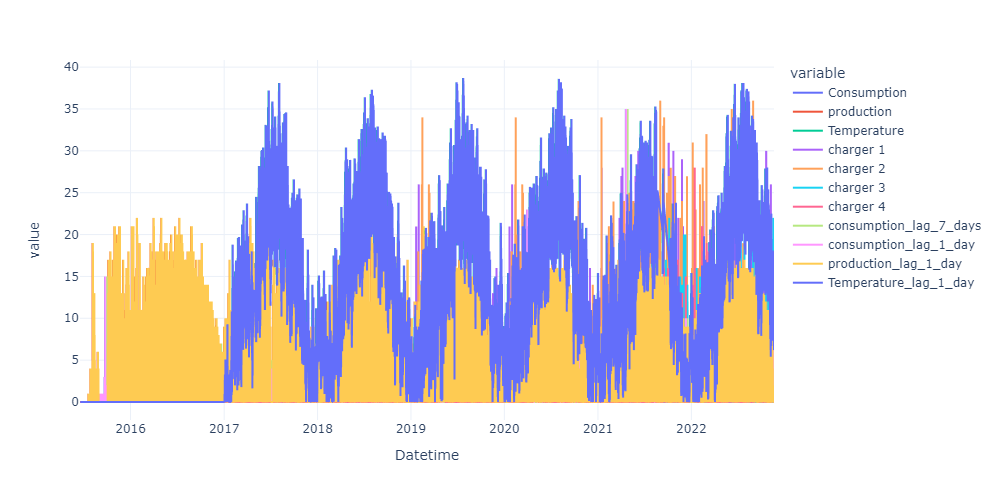

In [10]:
fig = px.line(df.drop(columns = ["day_of_year"]), template="plotly_white")

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

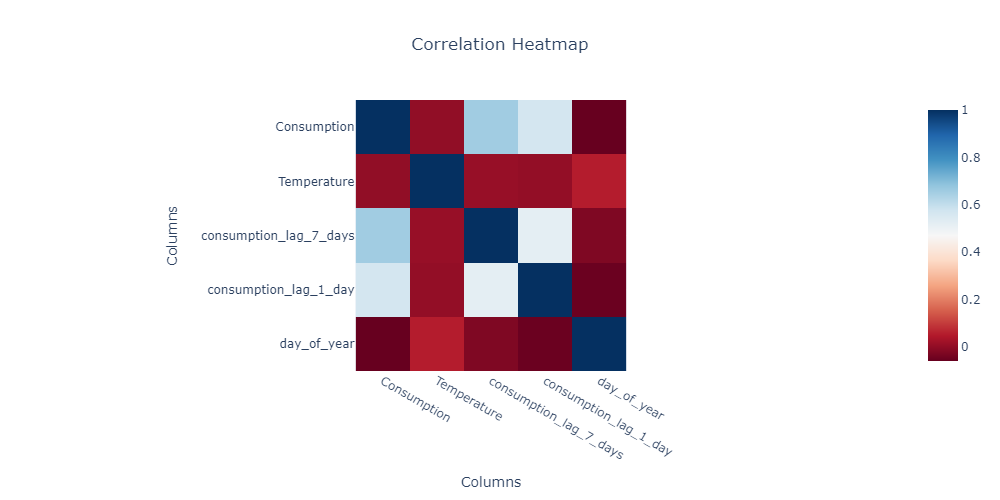

In [11]:
corr_matrix = df[['Consumption', 'Temperature', 'consumption_lag_7_days', 'consumption_lag_1_day', 'day_of_year']].corr()

fig = px.imshow(corr_matrix.values,
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                color_continuous_scale='RdBu',
                title='Correlation Heatmap')

# Add text annotations with correlation values
fig.update_traces(text=corr_matrix.values.round(2),
                  colorbar_thickness=20)

# Update layout
fig.update_layout(xaxis_title='Columns',
                  yaxis_title='Columns',
                  title_x=0.5)

# Display the heatmap
if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

## Split Data into train and test data sets
* Training dataset : 18th June 2015 to 31st December 2021
* Validation dataset: 1St January to 31st December 2022

In [12]:
# train_data = df.loc[df.index <"2020-03-16"]
train_data = df.loc[df.index <"2022-01-01"]
train_data = train_data.loc[train_data.index >="2015-06-18"]
test_data = df.loc[df.index >= "2022-01-01"]



## Forecasting Approaches:

>### eXtreme Gradient Boosting
EXtreme Gradient Boosting (XGBoost) is a supervised learning ML approach, is a scalable and efficient implementation of the gradient boosting approach proposed by Friedman. XGBoost has been demonstrated to be a highly capable and effective algorithm for forecasting across several domains \cite{chen_xgboost_2016}. The method is an ensemble algorithm that utilizes several models (typically decision trees) to produce a strong predictive model. The global model is based on sequentially arranged weaker models, with each subsequent model attempting to improve the error of the previous model (i.e., boosting).   
The method works by minimizing a given loss function, typically using a gradient descent approach. XGBoost is especially suitable for demand forecasting because it can efficiently handle both structured and unstructured data and can incorporate diverse features. For both demand and solar PV forecasting this is essential since both of these are dependent on many factors which include but are not limited to, weather, time of day, and the day of the week Furthermore, \acrshort{XGBoost} is capable of dealing with both missing data and outliers (both of which are typically present in many datasets) in the data in an effective manner and has been designed to identify and handle sparse data . The performance and generalization capabilities of XGBoost are enhanced by incorporating regularization techniques (typically L1 and L2) which penalize the complexity of the model and prevent overfitting. By controlling the complexity of the model, XGBoost achieves a good balance between bias and variance, leading to robust and accurate predictions. 
![fig39.png](../images/fig39.png)



>### Generalized Additive Models (GAMs)
According to Hastie et al, “Generalized additive models have the form $\eta(x)=\alpha + \sigma fj(xj)$, where $\eta$ might be the regression function in a multiple regression or the logistic transformation of the posterior probability $pr(y=1 | x)$ in a logistic regression. In fact, these models generalize the whole family of generalized linear models $\eta(x)=\beta^\prime x \eta(x) = \beta^\prime x$, where $\eta(x)=g(\mu(x))$ is some transformation of the regression function”. In simplified terms, A generalized additive model (GAM);  is a generalized linear model with a linear predictor involving a sum of smooth functions of continuous independent variables.   
Thus, GAMs are a statistical modeling-based approach that enables the fitting of a familiar family of non-linear functions. 
Typically, in a GAM, the response variable is a sum of smooth functions (these can take many forms, such as splines- piecewise polynomials that join smoothly at specific points) of the predictor. 
GAMs improve the general linear regression by facilitating a framework that captures both the linear and non-linear effects of the problem in a unified manner. Furthermore, GAMs are capable of relatively higher accuracy predictions due to the use of their non-linear fits  and can further provide the merit of automatic smoothness function selection wood_stable_2004. On the other hand, GAMs typically have high computational complexity and as such are prone to overfitting. Further, because GAMs are additive some important interactions can be missed, this can however be remedied by manually adding interaction terms. 

>### Light Gradient Boosting Machines (LGBMs): 
Like XGBoost, LGBM is an ML approach that utilizes a gradient boosting framework that is built on tree-based machine learning algorithms.  The main distinguishing factor is that whilst other tree-based algorithms grow trees horizontally, LGBM grows trees vertically (i.e., leaf-wise as against level-wise growth. Additionally, the method uses a histogram-based algorithm as described in, which results in faster training, and lower memory usage and also facilitates the use of advanced network communication to optimize parallel learning (Parallel voting DT algorithm). 
![fig40.png](../images/fig40.png)


>### Physical Model
This method is only applied to the prediction of solar PV generation and uses a deterministic method to evaluate solar PV production based on physical phenomena (geographical position, zenith, azimuth, day of the year, time of day, etc). In this work, we consider the Python package PVLib (PVLib is a python package proposed by NREL for modeling PV systems based on a physical model of such systems). The model also takes into account weather factors such as solar irradiance, wind speed temperature, and nebulosity as well as the physical characteristics of a solar PV module to estimate solar PV production.

>### Rule-Based (Naive) Predictors
These are predictors that are based on a simple rule (such as tomorrow’s consumption is the same as today’s consumption). The goal of these naive predictors is to use them as a baseline for assessing the performance of the more complex forecasts made with the algorithms discussed above. 


## Demand Forecast
Reshaping the datasets

Addition of ``is_holiday``, ``day_of_year`` and ``day_of_week`` features



In the ML approaches considered, various features were used to effectively learn the complex relationships and dependencies that exist between the proposed features and the building’s energy consumption. These input features can be classified into three main classes: 

1. **Calendar features**: These are features that can be extracted from a calendar and were constituted by: 

    * **Day_of_year**: this is a value between 1 and 365 that indicates which day of the year it is 

    * **Day_of_the_week**: this is a numerical value that represents which day of the week it is (1 for Sunday and 7 for Saturday). 

    * **Is_holiday**: this is a Boolean value that indicates if the day for which the forecasted profile is to be generated is a holiday or not with 1 indicating a holiday and 0 indicating it is not a holiday  

    * ** Is_weekend**: This is a Boolean value that indicates if the day for which the forecasted profile is to be generated is a weekend, with 1 indicating a weekend and 0 indicating a weekday. 

 

2. **Temporal features**: these account for exogenous factors that have an impact on the energy demand within the building. For the purpose of this application, only the external ambient temperature was considered. 

3. **Engineered features**: These were lagged variables, specifically: 
    * **consumption_lag_1_day**: This is the previous day’s consumption profile and allows for the model to capture immediate historical context for the forecast. 

    * **consumption_lag_ 7_days}: This is the previous week's consumption profile and allows for the model to have a medium-term insight into the demand patterns 



In [13]:

features = [ "consumption_lag_1_day","consumption_lag_7_days","Temperature"]
target = ["Consumption"]

obs = 24
x_train = reshape_(train_data[features], ref = features[1])
x_train = calendar(x_train,index = "index")

x_train["day_of_year"] = x_train.index.dayofyear
x_train["day_of_week"] = x_train.index.dayofweek

x_train = x_train.iloc[:-1]
x_train.fillna(0, inplace=True)

y_train = reshape_(train_data[target], ref = target[0])
y_train = y_train.iloc[:-1]


x_test = reshape_(test_data[features], ref = features[1])
x_test = calendar(x_test,index = "index")

x_test["day_of_year"] = x_test.index.dayofyear
x_test["day_of_week"] = x_test.index.day_of_week

x_test = x_test.iloc[:-1]
x_test.fillna(0, inplace=True)

y_test = reshape_(test_data[target], ref = target[0])
y_test = y_test.iloc[:-1]


### XGBOOST - Demand Forecasting

In [14]:
x_val = x_test.loc["2022-01-15":"2022-04-01"]

cols = x_train.columns.tolist()[24:]
reg = xgb.XGBRegressor(n_estimators = 1000000,early_stopping_rounds = 200,learning_rate = 0.01,
                       max_depth = 4,num_parallel_tree=4,max_leaves=7)
reg.fit(x_train[cols],y_train , eval_set = [(x_test[cols],y_test)],verbose = True )
cols = x_train.columns.tolist()[24:]
xgboost= reg.predict(x_test[cols])
xgboost = xgboost.flatten()

pickle.dump(reg, open('../ml_models/XGBOOST_Consumption_model.pkl', 'wb'))

[0]	validation_0-rmse:2.51567
[1]	validation_0-rmse:2.49786
[2]	validation_0-rmse:2.48004
[3]	validation_0-rmse:2.46262
[4]	validation_0-rmse:2.44541
[5]	validation_0-rmse:2.42840
[6]	validation_0-rmse:2.41130
[7]	validation_0-rmse:2.39473
[8]	validation_0-rmse:2.37826
[9]	validation_0-rmse:2.36176
[10]	validation_0-rmse:2.34559
[11]	validation_0-rmse:2.32947
[12]	validation_0-rmse:2.31353
[13]	validation_0-rmse:2.29802
[14]	validation_0-rmse:2.28281
[15]	validation_0-rmse:2.26746
[16]	validation_0-rmse:2.25223
[17]	validation_0-rmse:2.23732
[18]	validation_0-rmse:2.22260
[19]	validation_0-rmse:2.20814
[20]	validation_0-rmse:2.19378
[21]	validation_0-rmse:2.17968
[22]	validation_0-rmse:2.16553
[23]	validation_0-rmse:2.15175
[24]	validation_0-rmse:2.13804
[25]	validation_0-rmse:2.12438
[26]	validation_0-rmse:2.11102
[27]	validation_0-rmse:2.09786
[28]	validation_0-rmse:2.08480
[29]	validation_0-rmse:2.07167
[30]	validation_0-rmse:2.05878
[31]	validation_0-rmse:2.04601
[32]	validation_0-

[260]	validation_0-rmse:1.05235
[261]	validation_0-rmse:1.05145
[262]	validation_0-rmse:1.05072
[263]	validation_0-rmse:1.04992
[264]	validation_0-rmse:1.04916
[265]	validation_0-rmse:1.04841
[266]	validation_0-rmse:1.04766
[267]	validation_0-rmse:1.04689
[268]	validation_0-rmse:1.04611
[269]	validation_0-rmse:1.04529
[270]	validation_0-rmse:1.04455
[271]	validation_0-rmse:1.04393
[272]	validation_0-rmse:1.04327
[273]	validation_0-rmse:1.04248
[274]	validation_0-rmse:1.04182
[275]	validation_0-rmse:1.04117
[276]	validation_0-rmse:1.04049
[277]	validation_0-rmse:1.03980
[278]	validation_0-rmse:1.03910
[279]	validation_0-rmse:1.03854
[280]	validation_0-rmse:1.03790
[281]	validation_0-rmse:1.03730
[282]	validation_0-rmse:1.03668
[283]	validation_0-rmse:1.03604
[284]	validation_0-rmse:1.03544
[285]	validation_0-rmse:1.03487
[286]	validation_0-rmse:1.03426
[287]	validation_0-rmse:1.03366
[288]	validation_0-rmse:1.03313
[289]	validation_0-rmse:1.03260
[290]	validation_0-rmse:1.03212
[291]	va

[517]	validation_0-rmse:0.98817
[518]	validation_0-rmse:0.98814
[519]	validation_0-rmse:0.98811
[520]	validation_0-rmse:0.98806
[521]	validation_0-rmse:0.98805
[522]	validation_0-rmse:0.98797
[523]	validation_0-rmse:0.98793
[524]	validation_0-rmse:0.98789
[525]	validation_0-rmse:0.98788
[526]	validation_0-rmse:0.98782
[527]	validation_0-rmse:0.98776
[528]	validation_0-rmse:0.98772
[529]	validation_0-rmse:0.98767
[530]	validation_0-rmse:0.98761
[531]	validation_0-rmse:0.98759
[532]	validation_0-rmse:0.98755
[533]	validation_0-rmse:0.98755
[534]	validation_0-rmse:0.98749
[535]	validation_0-rmse:0.98745
[536]	validation_0-rmse:0.98742
[537]	validation_0-rmse:0.98735
[538]	validation_0-rmse:0.98735
[539]	validation_0-rmse:0.98727
[540]	validation_0-rmse:0.98724
[541]	validation_0-rmse:0.98722
[542]	validation_0-rmse:0.98722
[543]	validation_0-rmse:0.98718
[544]	validation_0-rmse:0.98716
[545]	validation_0-rmse:0.98709
[546]	validation_0-rmse:0.98704
[547]	validation_0-rmse:0.98698
[548]	va

[774]	validation_0-rmse:0.98377
[775]	validation_0-rmse:0.98375
[776]	validation_0-rmse:0.98377
[777]	validation_0-rmse:0.98374
[778]	validation_0-rmse:0.98375
[779]	validation_0-rmse:0.98374
[780]	validation_0-rmse:0.98375
[781]	validation_0-rmse:0.98376
[782]	validation_0-rmse:0.98374
[783]	validation_0-rmse:0.98373
[784]	validation_0-rmse:0.98372
[785]	validation_0-rmse:0.98372
[786]	validation_0-rmse:0.98372
[787]	validation_0-rmse:0.98371
[788]	validation_0-rmse:0.98371
[789]	validation_0-rmse:0.98372
[790]	validation_0-rmse:0.98370
[791]	validation_0-rmse:0.98371
[792]	validation_0-rmse:0.98374
[793]	validation_0-rmse:0.98372
[794]	validation_0-rmse:0.98372
[795]	validation_0-rmse:0.98375
[796]	validation_0-rmse:0.98375
[797]	validation_0-rmse:0.98373
[798]	validation_0-rmse:0.98373
[799]	validation_0-rmse:0.98372
[800]	validation_0-rmse:0.98370
[801]	validation_0-rmse:0.98371
[802]	validation_0-rmse:0.98372
[803]	validation_0-rmse:0.98371
[804]	validation_0-rmse:0.98370
[805]	va

### LGBM  - Demand Forecasting
Sequence to point (thus 24 models for 24 hour horizon)

In [15]:
##############LGBM#############################    


models, results = {}, {}
cols = [col for col in x_train.columns.tolist() if "Temp" not in col ]
prefix = "Consumption"
for col in y_train.columns:
    print (f"TRAINING Model for {col}")
    iteration = col.split("_")[-1]
    y_temp = y_train[col]
    y_val = y_test[col]
    x_te = x_test[cols+[f"Temperature_{iteration}"]]
    x_tr = x_train[cols+[f"Temperature_{iteration}"]]  
    
    print (y_temp, y_val)
#     sleep(10)
    model = reg = lgbm.LGBMRegressor(objective='regression',
        max_depth=4,
        num_leaves=5 ** 2 - 1,
        learning_rate=0.001,
        n_estimators=1000000,
        min_child_samples=80,
        subsample=0.8,
        colsample_bytree=1,
        reg_alpha=0,
        reg_lambda=0,
        random_state=np.random.randint(10e6)
    )
    model.fit(x_tr,y_temp , eval_set = [(x_te,y_val)],eval_names=('fit', 'val'),
            eval_metric='l2', early_stopping_rounds=200,
        feature_name=x_tr.columns.tolist(),verbose = True )
    
    models[f"model_{iteration}"] = model
    
    temp = model.predict(x_te)
    temp = temp.flatten()
    results[f"{prefix}_{iteration}"] = temp
    clear_output(wait=True)
    
print ('success')


pickle.dump(models, open('../ml_models/LGBM_Consumption_model.pkl', 'wb'))
        
lgb = reconstruct(results = results, prefix = prefix, horizon = 24)
 

success


### GAMs  - Demand Forecasting

In [16]:
cols = [col for col in x_train.columns.tolist() if "Temp" not in col ]


models, results = {}, {}
prefix = "Consumption"
for col in y_train.columns:
    print (f"TRAINING Model for {col}")
    iteration = col.split("_")[-1]

    x_te = x_test[cols+[f"Temperature_{iteration}"]]
    x_tr = x_train[cols+[f"Temperature_{iteration}"]]         
    y_temp = y_train[col]
    y_val = y_test[col]
    

    model  = LinearGAM()

    model.gridsearch(x_tr.to_numpy(), y_temp.to_numpy(),keep_best =True, )
    
    
    models[f"model_{iteration}"] = model
    
    temp = model.predict(x_te)
    temp = temp.flatten()
    results[f"{prefix}_{iteration}"] = temp
    clear_output(wait=True)
    
print ('success')

  
gams = reconstruct(results = results, prefix = prefix, horizon = 24)


pickle.dump(models, open('../ml_models/GAMS_Consumption_model.pkl', 'wb'))

success


### Visualize Predictions against Ground truths

A naive predictor (7day lag) is added to the forecasting results

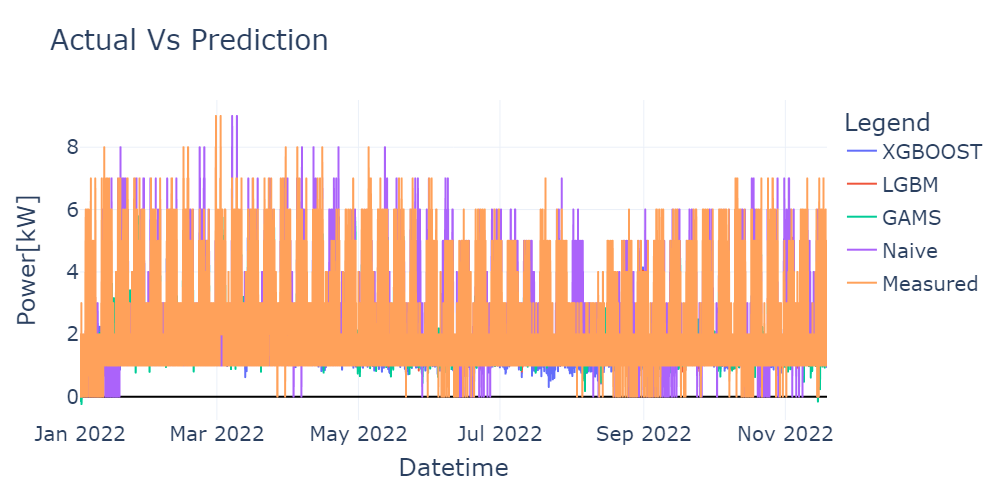

In [17]:
layout = {
   "font":{"size" : 20}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black'},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left','title_text': "Power[kW]"},
    "legend": {"tracegroupgap":4 ,"font_size": 20,"title" : "Legend"}
            }

## create Dataframe
df_conso = pd.DataFrame({"XGBOOST" :xgboost, "LGBM" :lgb,
                   "GAMS" : gams,
                   "Naive": test_data["consumption_lag_7_days"].iloc[:-1],
                   "Measured" :test_data[target[0]].iloc[:-(1 * 24)].tolist() },
                  index =test_data[target[0]].iloc[:-24].index )

df_conso.to_csv("../data/demand_prediction.csv",sep = ",",decimal = ".", index=True, index_label="Time")


fig = px.line(df_conso,template="plotly_white",title = "Actual Vs Prediction")
fig.update_layout(layout)
if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

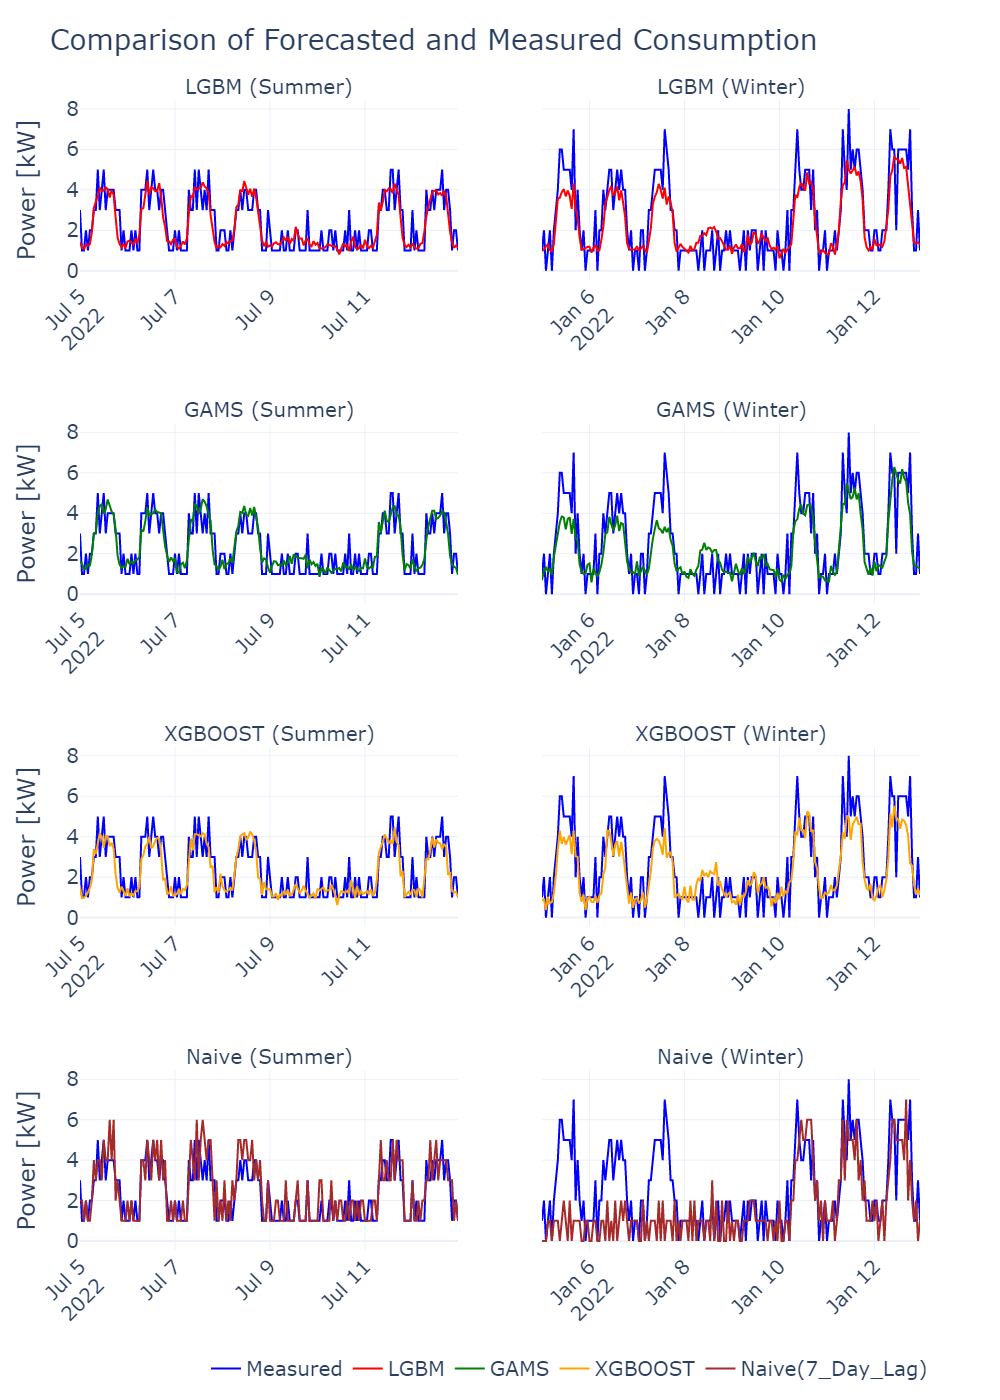

In [18]:



w,h = 1000, 1400
layout = {
    "title_text"  : 'Comparison of Forecasted and Measured Consumption',
   "font":{"size" : 20}, "template": "plotly_white", "width" : w, "height" : h,
    'xaxis': {"title_text" : "","tickangle" : -45},
    'xaxis2': { "title_text" : "","tickangle" : -45},
    'xaxis3': { "title_text" : "","tickangle" : -45},
    'xaxis4': {"title_text" : "","tickangle" : -45},
    'xaxis5': { "title_text" : "","tickangle" : -45},
    'xaxis6': { "title_text" : "","tickangle" : -45},
    'xaxis7': {"title_text" : "","tickangle" : -45},
    'xaxis8': { "title_text" : "","tickangle" : -45},
    'xaxis9': { "title_text" : "","tickangle" : -45},
    "yaxis": {"title_text" : 'Power [kW]'},
    "yaxis3": {"title_text" : 'Power [kW]'},
    "yaxis5": {"title_text" : 'Power [kW]'},
    "yaxis7": {"title_text" : 'Power [kW]'},   
     "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.12,"x":0.150, "title" : ""}
            }

df_ = df_conso.copy().loc["2022-07-05": "2022-07-12"]


fig = sp.make_subplots(rows=4, cols=2, subplot_titles=('LGBM (Summer)','LGBM (Winter)',
                                                       'GAMS (Summer)','GAMS (Winter)',
                                                       'XGBOOST (Summer)','XGBOOST (Winter)',
                                                       "Naive (Summer)" , "Naive (Winter)"),
                       shared_yaxes=True)

# Add the measured column to each subplot
col = 1
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', line_color='blue'),
              row=1, col= col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=3, col=col)

fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=4, col=col)


# Add the remaining columns to each subplot
fig.add_trace(go.Scatter(x=df_.index, y=df_['LGBM'], name='LGBM',line_color='red'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['GAMS'], name='GAMS',line_color='green'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['XGBOOST'], name='XGBOOST',line_color='orange'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Naive'], name='Naive(7_Day_Lag)',line_color='brown'), row=4, col=col)


df_ = df_conso.copy().loc["2022-01-05": "2022-01-12"]
col = 2
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=4, col=col)

row = 2
fig.add_trace(go.Scatter(x=df_.index, y=df_['LGBM'], name='LGBM',line_color='red', showlegend=False), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['GAMS'], name='GAMS',line_color='green', showlegend=False), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['XGBOOST'], name='XGBOOST',line_color='orange', showlegend=False), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Naive'], name='Naive(7_Day_Lag)',line_color='brown',showlegend=False), row=4, col=col)

fig.update_layout(layout)


fig.update_annotations(font_size=20)

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### Evaluation of  Forecasts

In [19]:



metric_list = ["r2_score", "mean_absolute_error","mean_squared_error",]

period = 1
df_evals = df_conso.copy()
cols = ["XGBOOST","LGBM","GAMS","Naive"]
for col in cols:
    
    for metric in metric_list:
        df_evals = prediction_error(df=df_evals, metric = metric , period =1, predict = col ,perfect = "Measured")

        
cols = [col for col in df_evals.columns if "MSE" in col or "MAE" in col or "R²" in col]

print ("######################################################################### \n  EVALUATION METRICS FOR 1 DAY HORIZON")
print (df_evals[cols].resample("1D").mean().describe().T[["min","max"]].sort_index())


period = 366
df_evals_1 = df_conso.copy()
cols = ["XGBOOST","LGBM","GAMS","Naive"]
for col in cols:
    
    for metric in metric_list:
        print (metric)
        df_evals_1 = prediction_error(df=df_evals_1, metric = metric , period =period, predict = col ,perfect = "Measured")
        
cols = [col for col in df_evals_1.columns if "MSE" in col or "MAE" in col or "R²" in col]
print ("######################################################################### \n EVALUATION METRICS FOR FULL HORIZON")
print(df_evals_1[cols].resample("1Y").mean().describe().T[["min","max"]].sort_index())

# px.line(tt,template="plotly_white",title = "Actual Vs Prediction")

######################################################################### 
  EVALUATION METRICS FOR 1 DAY HORIZON
                     min       max
MAE_[GAMS]      0.318855  1.742353
MAE_[LGBM]      0.243234  1.419268
MAE_[Naive]     0.333333  2.583333
MAE_[XGBOOST]   0.259516  1.773462
MSE_[GAMS]      0.174810  4.291891
MSE_[LGBM]      0.136293  3.371491
MSE_[Naive]     0.375000  9.583333
MSE_[XGBOOST]   0.105485  5.498012
R²_[GAMS]     -13.046187  0.876101
R²_[LGBM]      -8.423772  0.888712
R²_[Naive]    -20.818182  0.870060
R²_[XGBOOST]   -8.347032  0.859802
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
######################################################################### 
 EVALUATION METRICS FOR FULL HORIZON
                    min       max
MAE_[GAMS]     0.727437  0.727437
MAE_[LGBM]     0.684968  0.684968
MAE_[Naive]    0.855719  

### comment

The results show comparable performance in the summer, however in the winter the GAMs algorithm showed a tendency to under-predict. The evaluation of these algorithms using the performance metrics discussed in sub-chapter (considering a one-day (24-hour) evaluation period) indicates that for all three metrics, LGBM produced the best daily predictions with lower error values and the highest R² value achieved. Also, to be noted is that the naïve approach, despite being simple yielded results that were not very far from those of the ML algorithms considered.

## Production Forecast
Reshaping the datasets

Addition of ``is_holiday``, ``day_of_year`` and ``day_of_week`` features

The considered algorithms used the following as input features to establish relationships and patterns between the proposed features and the solar PV production (i.e., the desired output): 


1. **Day_of_year**: this is a value between 1 and 365 that indicates which day of the year it is 

2. **Temperature_lag_1_day**: This is the temperature profile for the previous day 

3. **Temperature_lead_1_day**: This is the temperature profile for the next day 

4. **Production_lag_1_day**: This is the solar \acrshort{PV} production profile of the previous day. 


In [20]:
train_data["production_lag_1_day"]  = train_data.production.shift(24 * 1)
train_data["Temperature_lag_1_day"]  = train_data.Temperature.shift(24 *1 )


test_data["production_lag_1_day"]  = test_data.production.shift(24 * 1)
test_data["Temperature_lag_1_day"]  = test_data.Temperature.shift(24 *1 )


In [21]:
features = [ "production_lag_1_day","Temperature_lag_1_day","Temperature"]
target = ["production"]

obs = 24
x_train = reshape_(train_data[features], ref = features[1])
x_train = calendar(x_train,index = "index")

x_train["day_of_year"] = x_train.index.dayofyear
x_train["day_of_week"] = x_train.index.dayofweek


x_train = x_train.iloc[:-1]
x_train.fillna(0, inplace=True)

y_train = reshape_(train_data[target], ref = target[0])
y_train = y_train.iloc[:-1]


x_test = reshape_(test_data[features], ref = features[1])
x_test = calendar(x_test,index = "index")


x_test["day_of_year"] = x_test.index.dayofyear
x_test["day_of_week"] = x_test.index.day_of_week

x_test = x_test.iloc[:-1]
x_test.fillna(0, inplace=True)

y_test = reshape_(test_data[target], ref = target[0])
y_test = y_test.iloc[:-1]



### XGBOOST  - Demand Forecasting

In [22]:

##############XGBOOST#############################    

x_val = x_test.loc["2022-01-15":"2022-04-01"]

cols = x_train.columns.tolist()[24:]
reg_p = xgb.XGBRegressor(n_estimators = 1000000,early_stopping_rounds = 200,learning_rate = 0.01,
                       max_depth = 4,num_parallel_tree=4,max_leaves=7)
reg_p.fit(x_train[cols],y_train , eval_set = [(x_test[cols],y_test)],verbose = True )
cols = x_train.columns.tolist()[24:]
xgboost_p= reg_p.predict(x_test[cols])
xgboost_p = xgboost_p.flatten()



pickle.dump(reg_p, open('../ml_models/XGBOOST_Production_model.pkl', 'wb'))

[0]	validation_0-rmse:5.31304
[1]	validation_0-rmse:5.26877
[2]	validation_0-rmse:5.22527
[3]	validation_0-rmse:5.18203
[4]	validation_0-rmse:5.13942
[5]	validation_0-rmse:5.09716
[6]	validation_0-rmse:5.05544
[7]	validation_0-rmse:5.01427
[8]	validation_0-rmse:4.97349
[9]	validation_0-rmse:4.93334
[10]	validation_0-rmse:4.89343
[11]	validation_0-rmse:4.85368
[12]	validation_0-rmse:4.81466
[13]	validation_0-rmse:4.77592
[14]	validation_0-rmse:4.73786
[15]	validation_0-rmse:4.69992
[16]	validation_0-rmse:4.66277
[17]	validation_0-rmse:4.62573
[18]	validation_0-rmse:4.58890
[19]	validation_0-rmse:4.55250
[20]	validation_0-rmse:4.51640
[21]	validation_0-rmse:4.48126
[22]	validation_0-rmse:4.44611
[23]	validation_0-rmse:4.41143
[24]	validation_0-rmse:4.37701
[25]	validation_0-rmse:4.34321
[26]	validation_0-rmse:4.30970
[27]	validation_0-rmse:4.27678
[28]	validation_0-rmse:4.24431
[29]	validation_0-rmse:4.21173
[30]	validation_0-rmse:4.17967
[31]	validation_0-rmse:4.14800
[32]	validation_0-

[260]	validation_0-rmse:1.80766
[261]	validation_0-rmse:1.80619
[262]	validation_0-rmse:1.80483
[263]	validation_0-rmse:1.80345
[264]	validation_0-rmse:1.80235
[265]	validation_0-rmse:1.80090
[266]	validation_0-rmse:1.79947
[267]	validation_0-rmse:1.79804
[268]	validation_0-rmse:1.79670
[269]	validation_0-rmse:1.79545
[270]	validation_0-rmse:1.79426
[271]	validation_0-rmse:1.79308
[272]	validation_0-rmse:1.79185
[273]	validation_0-rmse:1.79065
[274]	validation_0-rmse:1.78939
[275]	validation_0-rmse:1.78820
[276]	validation_0-rmse:1.78718
[277]	validation_0-rmse:1.78599
[278]	validation_0-rmse:1.78489
[279]	validation_0-rmse:1.78382
[280]	validation_0-rmse:1.78283
[281]	validation_0-rmse:1.78179
[282]	validation_0-rmse:1.78072
[283]	validation_0-rmse:1.77969
[284]	validation_0-rmse:1.77863
[285]	validation_0-rmse:1.77763
[286]	validation_0-rmse:1.77677
[287]	validation_0-rmse:1.77583
[288]	validation_0-rmse:1.77468
[289]	validation_0-rmse:1.77371
[290]	validation_0-rmse:1.77283
[291]	va

[517]	validation_0-rmse:1.70635
[518]	validation_0-rmse:1.70628
[519]	validation_0-rmse:1.70607
[520]	validation_0-rmse:1.70599
[521]	validation_0-rmse:1.70581
[522]	validation_0-rmse:1.70576
[523]	validation_0-rmse:1.70561
[524]	validation_0-rmse:1.70534
[525]	validation_0-rmse:1.70523
[526]	validation_0-rmse:1.70503
[527]	validation_0-rmse:1.70475
[528]	validation_0-rmse:1.70467
[529]	validation_0-rmse:1.70460
[530]	validation_0-rmse:1.70453
[531]	validation_0-rmse:1.70429
[532]	validation_0-rmse:1.70409
[533]	validation_0-rmse:1.70409
[534]	validation_0-rmse:1.70409
[535]	validation_0-rmse:1.70408
[536]	validation_0-rmse:1.70385
[537]	validation_0-rmse:1.70386
[538]	validation_0-rmse:1.70374
[539]	validation_0-rmse:1.70361
[540]	validation_0-rmse:1.70360
[541]	validation_0-rmse:1.70344
[542]	validation_0-rmse:1.70316
[543]	validation_0-rmse:1.70303
[544]	validation_0-rmse:1.70289
[545]	validation_0-rmse:1.70278
[546]	validation_0-rmse:1.70263
[547]	validation_0-rmse:1.70260
[548]	va

[774]	validation_0-rmse:1.68973
[775]	validation_0-rmse:1.68954
[776]	validation_0-rmse:1.68945
[777]	validation_0-rmse:1.68941
[778]	validation_0-rmse:1.68939
[779]	validation_0-rmse:1.68931
[780]	validation_0-rmse:1.68914
[781]	validation_0-rmse:1.68901
[782]	validation_0-rmse:1.68891
[783]	validation_0-rmse:1.68891
[784]	validation_0-rmse:1.68891
[785]	validation_0-rmse:1.68889
[786]	validation_0-rmse:1.68869
[787]	validation_0-rmse:1.68851
[788]	validation_0-rmse:1.68848
[789]	validation_0-rmse:1.68842
[790]	validation_0-rmse:1.68847
[791]	validation_0-rmse:1.68841
[792]	validation_0-rmse:1.68834
[793]	validation_0-rmse:1.68826
[794]	validation_0-rmse:1.68822
[795]	validation_0-rmse:1.68814
[796]	validation_0-rmse:1.68803
[797]	validation_0-rmse:1.68795
[798]	validation_0-rmse:1.68798
[799]	validation_0-rmse:1.68794
[800]	validation_0-rmse:1.68786
[801]	validation_0-rmse:1.68785
[802]	validation_0-rmse:1.68782
[803]	validation_0-rmse:1.68783
[804]	validation_0-rmse:1.68784
[805]	va

[1030]	validation_0-rmse:1.68070
[1031]	validation_0-rmse:1.68067
[1032]	validation_0-rmse:1.68064
[1033]	validation_0-rmse:1.68070
[1034]	validation_0-rmse:1.68073
[1035]	validation_0-rmse:1.68076
[1036]	validation_0-rmse:1.68074
[1037]	validation_0-rmse:1.68074
[1038]	validation_0-rmse:1.68071
[1039]	validation_0-rmse:1.68063
[1040]	validation_0-rmse:1.68064
[1041]	validation_0-rmse:1.68069
[1042]	validation_0-rmse:1.68066
[1043]	validation_0-rmse:1.68061
[1044]	validation_0-rmse:1.68050
[1045]	validation_0-rmse:1.68050
[1046]	validation_0-rmse:1.68064
[1047]	validation_0-rmse:1.68063
[1048]	validation_0-rmse:1.68067
[1049]	validation_0-rmse:1.68070
[1050]	validation_0-rmse:1.68074
[1051]	validation_0-rmse:1.68072
[1052]	validation_0-rmse:1.68061
[1053]	validation_0-rmse:1.68051
[1054]	validation_0-rmse:1.68056
[1055]	validation_0-rmse:1.68058
[1056]	validation_0-rmse:1.68057
[1057]	validation_0-rmse:1.68049
[1058]	validation_0-rmse:1.68048
[1059]	validation_0-rmse:1.68052
[1060]	val

### LGBM

In [23]:
##############LGBM#############################    


models, results = {}, {}
cols = [col for col in x_train.columns.tolist() if "lag" not in col  ]
prefix = "Consumption"
for col in y_train.columns:
    print (f"TRAINING Model for {col}")
    iteration = col.split("_")[-1]
    y_temp = y_train[col]
    y_val = y_test[col]
    x_te = x_test[cols+[f"Temperature_lag_1_day_{iteration}", f"production_lag_1_day_{iteration}"]]
    
    x_tr = x_train[cols+[f"Temperature_lag_1_day_{iteration}", f"production_lag_1_day_{iteration}"] ] 
    
    print (y_temp, y_val)
#     sleep(10)
    model = reg = lgbm.LGBMRegressor(objective='regression',
        max_depth=4,
        num_leaves=5 ** 2 - 1,
        learning_rate=0.01,
        n_estimators=1000000,
        min_child_samples=80,
        subsample=0.8,
        colsample_bytree=1,
        reg_alpha=0,
        reg_lambda=0,
        random_state=np.random.randint(10e6)
    )
    model.fit(x_tr,y_temp , eval_set = [(x_te,y_val)],eval_names=('fit', 'val'),
            eval_metric='l2', early_stopping_rounds=200,
        feature_name=x_tr.columns.tolist(),verbose = True )
    
    models[f"model_{iteration}"] = model
    
    temp = model.predict(x_te)
    temp = temp.flatten()
    results[f"{prefix}_{iteration}"] = temp
    clear_output(wait=True)
    
print ('success')

        
lgb_p = reconstruct(results = results, prefix = prefix, horizon = 24)



pickle.dump(models, open('../ml_models/XGBOOST_Production_model.pkl', 'wb'))

success


### GAMs

In [24]:
#################GAM################################
# cols = x_train.columns.tolist()[24:]


models, results = {}, {}
prefix = "Consumption"
for col in y_train.columns:
    print (f"TRAINING Model for {col}")
    iteration = col.split("_")[-1]

    x_te = x_test[cols+[f"Temperature_lag_1_day_{iteration}",f"production_lag_1_day_{iteration}"]]
    x_tr = x_train[cols+[f"Temperature_lag_1_day_{iteration}",f"production_lag_1_day_{iteration}"]]
    y_temp = y_train[col]
    y_val = y_test[col]
    

    model  = LinearGAM()

    model.gridsearch(x_tr.to_numpy(), y_temp.to_numpy(),keep_best =True, )
    
    
    models[f"model_{iteration}"] = model
    
    temp = model.predict(x_te)
    temp = temp.flatten()
    results[f"{prefix}_{iteration}"] = temp
    clear_output(wait=True)
    
print ('success')

  
gams_p = reconstruct(results = results, prefix = prefix, horizon = 24)


pickle.dump(models, open('../ml_models/GAMS_Production_model.pkl', 'wb'))

success


### Physical Model - PV forecasting

for this model we added the following features:

1.  **Wind_speed_lead_1_day**: this is the wind speed profile for the next day 

2. **Nebulosity_lead_1_day** : this is the cloud cover (in percentage) of the next day (however, this data was available only until the end of 2021) 

In [25]:
###############PHYSICAL MODEL###############

temp = pd.concat(map(pd.read_csv,n_filepaths),axis = 0)
temp = temp.set_index(pd.to_datetime(temp.Time), inplace =False)
temp.sort_index(inplace=True)
temp.drop (columns = "Time")
temp = temp.resample("1H").mean()
temp = temp.loc["2022-01-01": "2022-11-19"]


test_data["wind_speed"] = temp["Wind Speed"].tolist()
df_met, test_data = gen_sloar_pow(df=test_data, lattitude =45.19144 , longitude =5.714258)
test_data["PV_prod_pvlib"] = test_data.PV_prod_pvlib.shift(2) 

### Visualisation of Results

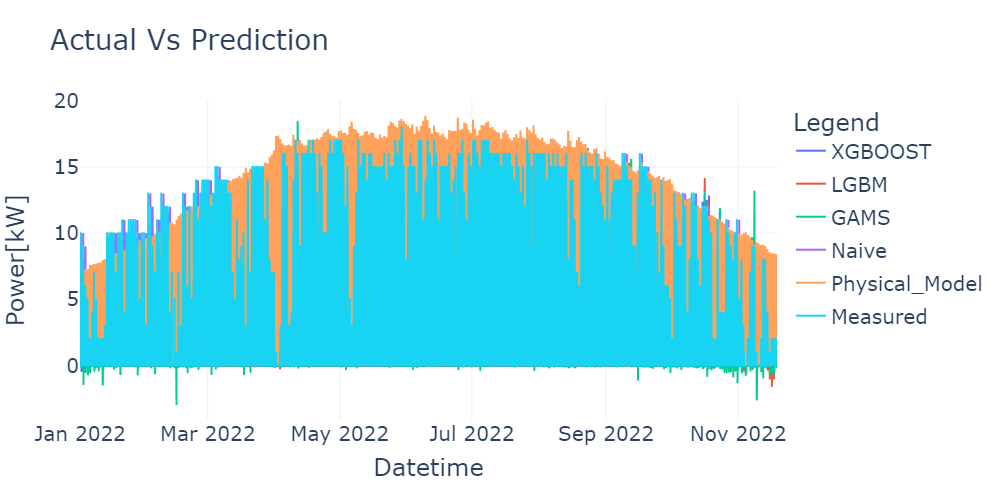

In [26]:
layout = {
   "font":{"size" : 20}, "template": "plotly_white",
    'xaxis': {'zerolinewidth': 2,'zerolinecolor':'black'},
    "yaxis": {'zerolinewidth': 2,'zerolinecolor':'black',"side": 'left','title_text': "Power[kW]"},
    "legend": {"tracegroupgap":4 ,"font_size": 20,"title" : "Legend"}
            }

df_prod = pd.DataFrame({"XGBOOST" :xgboost_p, "LGBM" :lgb_p,
                   "GAMS" : gams_p,
                   "Naive": test_data["production_lag_1_day"].iloc[:-1],
                    "Physical_Model" : test_data["PV_prod_pvlib"].iloc[:-(1 * 24)].tolist() ,
                   "Measured" :test_data[target[0]].iloc[:-(1 * 24)].tolist()
                       },
                    index =test_data[target[0]].iloc[:-24].index )

df_prod.to_csv("../data/production_prediction.csv",sep = ",",decimal = ".", index=True, 
               index_label="Time")

fig = px.line(df_prod,template="plotly_white",title = "Actual Vs Prediction")

fig.update_layout(layout)
if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

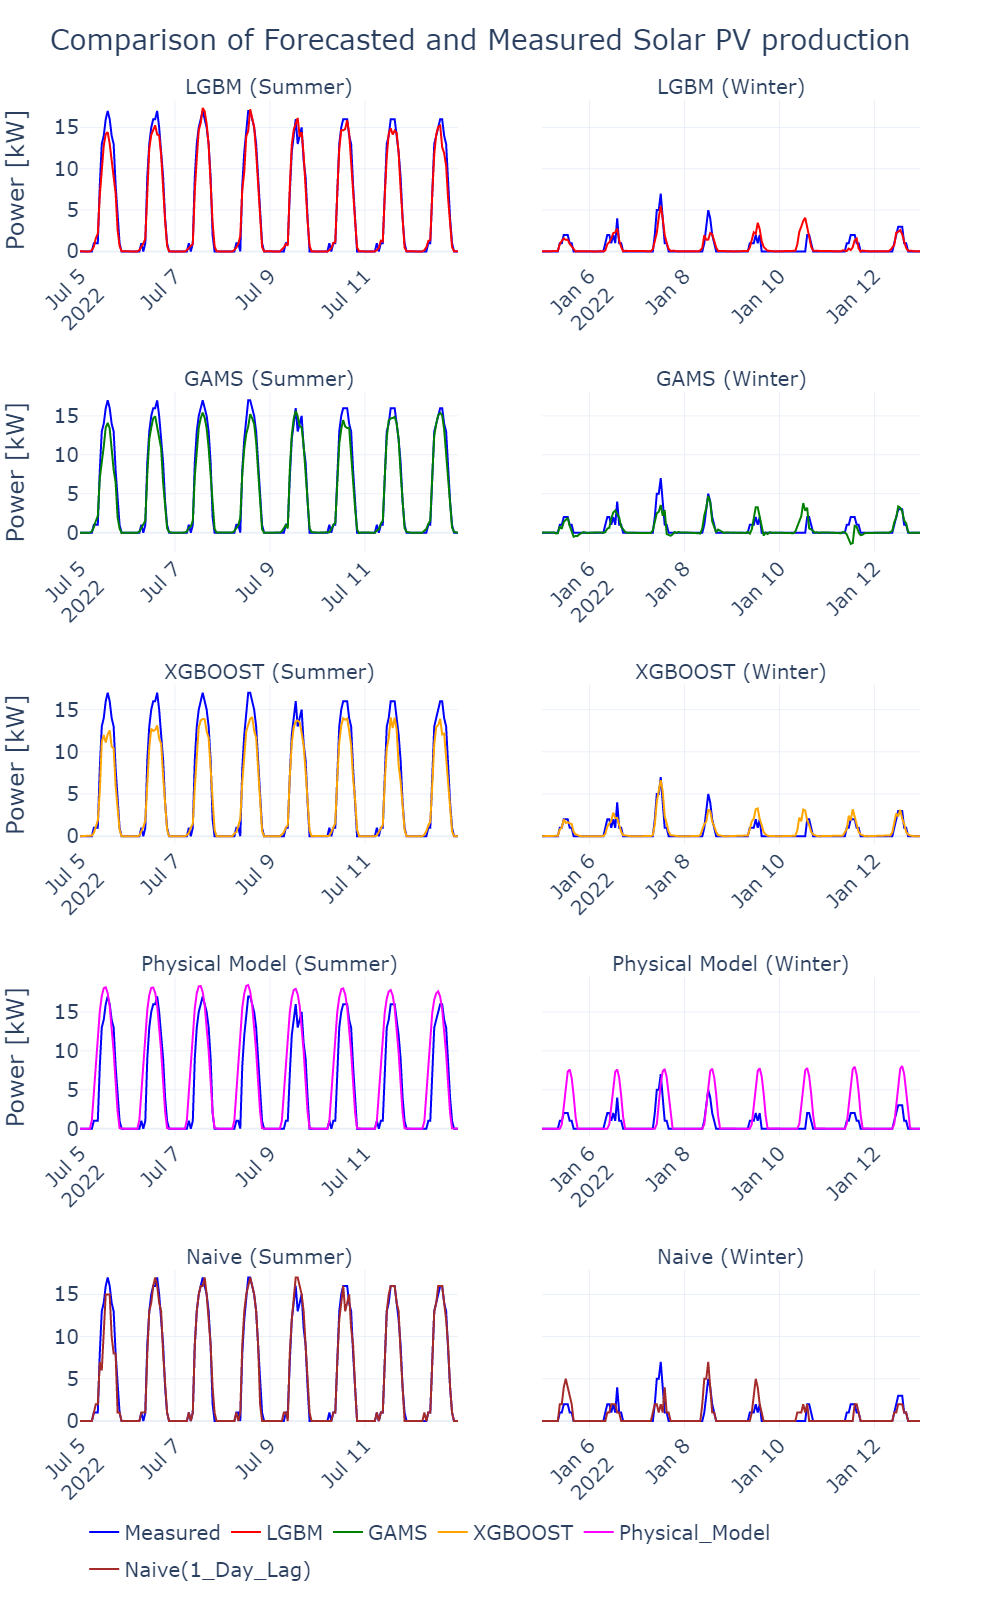

In [27]:
w ,h = 1200, 1600
layout = {
    "title_text"  : 'Comparison of Forecasted and Measured Solar PV production',
   "font":{"size" : 20}, "template": "plotly_white", "width" : w, "height" : h,
    'xaxis': {"title_text" : "","tickangle" : -45},
    'xaxis2': { "title_text" : "","tickangle" : -45},
    'xaxis3': { "title_text" : "","tickangle" : -45},
    'xaxis4': {"title_text" : "","tickangle" : -45},
    'xaxis5': { "title_text" : "","tickangle" : -45},
    'xaxis6': { "title_text" : "","tickangle" : -45},
    'xaxis7': { "title_text" : "","tickangle" : -45},
    'xaxis8': { "title_text" : "","tickangle" : -45},
    'xaxis9': { "title_text" : "","tickangle" : -45},
    'xaxis10': { "title_text" : "","tickangle" : -45},
    "yaxis1": {"title_text" : 'Power [kW]'},
    "yaxis3": {"title_text" : 'Power [kW]'},
    "yaxis5": {"title_text" : 'Power [kW]'},
    "yaxis7": {"title_text" : 'Power [kW]'},
    "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.12,"x":0.0050, "title" : ""}
            }




df_ = df_prod.copy().loc["2022-07-05": "2022-07-12"]
# Create subplots with 1 row and 3 columns, sharing the y-axis
fig = sp.make_subplots(rows=5, cols=2, subplot_titles=('LGBM (Summer)','LGBM (Winter)',
                                                       'GAMS (Summer)','GAMS (Winter)',
                                                       'XGBOOST (Summer)','XGBOOST (Winter)',
                                                       'Physical Model (Summer)','Physical Model (Winter)',
                                                      "Naive (Summer)", "Naive (Winter)"),shared_yaxes=True)

# Add the measured column to each subplot
col = 1
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=True,
                         line_color='blue'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=5, col=col)


# Add the remaining columns to each subplot
fig.add_trace(go.Scatter(x=df_.index, y=df_['LGBM'], name='LGBM',line_color='red'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['GAMS'], name='GAMS',line_color='green'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['XGBOOST'], name='XGBOOST',line_color='orange'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Physical_Model'], name='Physical_Model',line_color='magenta',
                         showlegend=True,), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Naive'], name='Naive(1_Day_Lag)',line_color='brown',
                         showlegend=True,), row=5, col=col)

df_ = df_prod.copy().loc["2022-01-05": "2022-01-12"]
col = 2
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=5, col=col)


fig.add_trace(go.Scatter(x=df_.index, y=df_['LGBM'], name='LGBM',line_color='red', showlegend=False), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['GAMS'], name='GAMS',line_color='green', showlegend=False), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['XGBOOST'], name='XGBOOST',line_color='orange', showlegend=False),
              row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Physical_Model'], name='Phys_Model',line_color='magenta',
                         showlegend=False), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Naive'], name='Naive(1_Day_Lag)',line_color='brown',
                         showlegend=False,), row=5, col=col)
fig.update_layout(layout)



fig.update_annotations(font_size=20)
fig.update_layout(legend=dict(orientation="h"))


if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### Evaluation of  Forecasts

In [28]:
metric_list = ["r2_score", "mean_absolute_error","mean_squared_error",]

period = 1
df_evals_1 = df_prod.copy().interpolate()
df_evals_1 = df_evals_1.iloc[24:]
cols = ["XGBOOST","LGBM","GAMS","Physical_Model","Naive"]
for col in cols:
    
    for metric in metric_list:
        print (metric)
        df_evals_1 = prediction_error(df=df_evals_1, metric = metric , period =period, predict = col ,perfect = "Measured")
        
cols = [col for col in df_evals_1.columns if "MSE" in col or "MAE" in col or "R²" in col]
# print (cols)
df_evals_1[cols].resample("1D").mean().describe().T[["min","max"]].sort_index()

r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error


min        max
MAE_[GAMS]              0.102984   2.210768
MAE_[LGBM]              0.126509   2.209753
MAE_[Naive]             0.041667   3.458333
MAE_[Physical_Model]    0.553993   5.417970
MAE_[XGBOOST]           0.117102   2.271567
MSE_[GAMS]              0.031571  13.093945
MSE_[LGBM]              0.050963  15.141095
MSE_[Naive]             0.041667  36.125000
MSE_[Physical_Model]    1.292825  72.864083
MSE_[XGBOOST]           0.045458  16.012834
R²_[GAMS]             -34.114851   0.996434
R²_[LGBM]             -59.278617   0.996028
R²_[Naive]           -230.652174   0.997225
R²_[Physical_Model]  -627.904912   0.920203
R²_[XGBOOST]          -78.779216   0.997223

In [29]:
metric_list = ["r2_score", "mean_absolute_error","mean_squared_error",]

period = 366
# df_evals_1 = df_evals_1.iloc[24:]
df_evals_1 = df_prod.copy().interpolate()
df_evals_1 = df_evals_1.iloc[24:]
cols = ["XGBOOST","LGBM","GAMS","Physical_Model","Naive"]
for col in cols:
    
    for metric in metric_list:
        print (metric)
        df_evals_1 = prediction_error(df=df_evals_1, metric = metric , period =period, predict = col ,perfect = "Measured")
        
cols = [col for col in df_evals_1.columns if "MSE" in col or "MAE" in col or "R²" in col]
# print (cols)
df_evals_1[cols].resample("1Y").mean().describe().T[["min","max"]].sort_index()

r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error


min        max
MAE_[GAMS]             0.756448   0.756448
MAE_[LGBM]             0.775254   0.775254
MAE_[Naive]            0.977285   0.977285
MAE_[Physical_Model]   2.037407   2.037407
MAE_[XGBOOST]          0.837165   0.837165
MSE_[GAMS]             2.248964   2.248964
MSE_[LGBM]             2.481451   2.481451
MSE_[Naive]            5.321781   5.321781
MSE_[Physical_Model]  13.764864  13.764864
MSE_[XGBOOST]          2.826140   2.826140
R²_[GAMS]              0.900968   0.900968
R²_[LGBM]              0.890731   0.890731
R²_[Naive]             0.765658   0.765658
R²_[Physical_Model]    0.393872   0.393872
R²_[XGBOOST]           0.875553   0.875553

### comment
A comparison of the results from the three ML models and the physical model shows that the GAM model suffers from a tendency to predict negative values, whilst XGBoost and LGBM were able to effectively capture the relationship between the input features and the solar PV production. The physical model, however, did not yield good results, particularly in the winter months, possibly due to a lack of nebulosity (cloud cover) and potential shading from the building. 

## EV Demand profile prediction


* Due to the sparse nature of the data, a Support Vector Machine approach was also considered in addition to the already discussed ML algorithms. 

* For this application, the naïve predictor was considered to be the daily energy demand of the previous week. The input features for this application were: 


The input features for this application were: 



* **day_of_the_week**: this was represented as an integer value between 1 (i.e., Sunday) and 7 (Saturday). 

* **Is_holiday**: this was a Boolean value, with 1 (True) indicating the day for which the demand is to be forecasted is a holiday and 0 (False) indicating it is not a holiday. 

In [30]:
df_ev = df[["charger 1", "charger 2","charger 3","charger 4"]].copy()
df_ev[df_ev <= 1] = 0
df_ev["Aggregated_consumption"] = df_ev.sum(axis=1)



In [31]:
df_ev = df_ev.resample("1D").sum()


In [32]:
df_ev = df_ev[["Aggregated_consumption"]]
df_ev["day_of_week"] = df_ev.index.dayofweek
df_ev = calendar(df_ev,index = "Datetime")


for x in range (1,15):
    df_ev[f"Aggregated_consumption_lag_{x}"] = df_ev["Aggregated_consumption"].shift(x)
    
y_train = df_ev["Aggregated_consumption"].loc["2020-01-01": "2021-12-31"]
x_train = df_ev.loc["2020-01-01": "2021-12-31"].drop(columns = "Aggregated_consumption")

y_test = df_ev["Aggregated_consumption"].loc["2022-01-01": ]
x_test = df_ev.loc["2022-01-01":].drop(columns = "Aggregated_consumption")
# .loc["2020-01-01":"2022-O6-30"]

### XGBOOST - EV Demand profile prediction

In [33]:
reg_ev = xgb.XGBRegressor(n_estimators = 1000000,early_stopping_rounds = 200,learning_rate = 0.001,
                       max_depth = 5,num_parallel_tree=4,max_leaves=8)
reg_ev.fit(x_train,y_train , eval_set = [(x_test,y_test)],verbose = True )

xgboost_ev= reg_ev.predict(x_test)
xgboost_ev = xgboost_ev.flatten()

pickle.dump(reg_ev, open('../ml_models/XGBOOST_EV_Demand_model.pkl', 'wb'))

[0]	validation_0-rmse:27.47572
[1]	validation_0-rmse:27.46374
[2]	validation_0-rmse:27.45178
[3]	validation_0-rmse:27.43984
[4]	validation_0-rmse:27.42792
[5]	validation_0-rmse:27.41601
[6]	validation_0-rmse:27.40412
[7]	validation_0-rmse:27.39225
[8]	validation_0-rmse:27.38040
[9]	validation_0-rmse:27.36856
[10]	validation_0-rmse:27.35674
[11]	validation_0-rmse:27.34494
[12]	validation_0-rmse:27.33316
[13]	validation_0-rmse:27.32139
[14]	validation_0-rmse:27.30964
[15]	validation_0-rmse:27.29791
[16]	validation_0-rmse:27.28620
[17]	validation_0-rmse:27.27451
[18]	validation_0-rmse:27.26283
[19]	validation_0-rmse:27.25117
[20]	validation_0-rmse:27.23952
[21]	validation_0-rmse:27.22790
[22]	validation_0-rmse:27.21629
[23]	validation_0-rmse:27.20470
[24]	validation_0-rmse:27.19313
[25]	validation_0-rmse:27.18157
[26]	validation_0-rmse:27.17003
[27]	validation_0-rmse:27.15845
[28]	validation_0-rmse:27.14695
[29]	validation_0-rmse:27.13541
[30]	validation_0-rmse:27.12388
[31]	validation_0-

[252]	validation_0-rmse:24.91074
[253]	validation_0-rmse:24.90202
[254]	validation_0-rmse:24.89425
[255]	validation_0-rmse:24.88575
[256]	validation_0-rmse:24.87730
[257]	validation_0-rmse:24.86885
[258]	validation_0-rmse:24.86088
[259]	validation_0-rmse:24.85287
[260]	validation_0-rmse:24.84405
[261]	validation_0-rmse:24.83637
[262]	validation_0-rmse:24.82786
[263]	validation_0-rmse:24.81960
[264]	validation_0-rmse:24.81164
[265]	validation_0-rmse:24.80266
[266]	validation_0-rmse:24.79431
[267]	validation_0-rmse:24.78620
[268]	validation_0-rmse:24.77776
[269]	validation_0-rmse:24.76985
[270]	validation_0-rmse:24.76197
[271]	validation_0-rmse:24.75363
[272]	validation_0-rmse:24.74551
[273]	validation_0-rmse:24.73724
[274]	validation_0-rmse:24.72925
[275]	validation_0-rmse:24.72139
[276]	validation_0-rmse:24.71303
[277]	validation_0-rmse:24.70529
[278]	validation_0-rmse:24.69666
[279]	validation_0-rmse:24.68892
[280]	validation_0-rmse:24.68064
[281]	validation_0-rmse:24.67308
[282]	vali

[501]	validation_0-rmse:23.11667
[502]	validation_0-rmse:23.11045
[503]	validation_0-rmse:23.10497
[504]	validation_0-rmse:23.09936
[505]	validation_0-rmse:23.09363
[506]	validation_0-rmse:23.08769
[507]	validation_0-rmse:23.08225
[508]	validation_0-rmse:23.07574
[509]	validation_0-rmse:23.06979
[510]	validation_0-rmse:23.06350
[511]	validation_0-rmse:23.05736
[512]	validation_0-rmse:23.05197
[513]	validation_0-rmse:23.04614
[514]	validation_0-rmse:23.03984
[515]	validation_0-rmse:23.03377
[516]	validation_0-rmse:23.02754
[517]	validation_0-rmse:23.02146
[518]	validation_0-rmse:23.01604
[519]	validation_0-rmse:23.01087
[520]	validation_0-rmse:23.00538
[521]	validation_0-rmse:22.99928
[522]	validation_0-rmse:22.99347
[523]	validation_0-rmse:22.98731
[524]	validation_0-rmse:22.98224
[525]	validation_0-rmse:22.97599
[526]	validation_0-rmse:22.97055
[527]	validation_0-rmse:22.96423
[528]	validation_0-rmse:22.95914
[529]	validation_0-rmse:22.95312
[530]	validation_0-rmse:22.94695
[531]	vali

[750]	validation_0-rmse:21.83845
[751]	validation_0-rmse:21.83387
[752]	validation_0-rmse:21.82938
[753]	validation_0-rmse:21.82557
[754]	validation_0-rmse:21.82124
[755]	validation_0-rmse:21.81677
[756]	validation_0-rmse:21.81314
[757]	validation_0-rmse:21.80866
[758]	validation_0-rmse:21.80445
[759]	validation_0-rmse:21.80014
[760]	validation_0-rmse:21.79647
[761]	validation_0-rmse:21.79229
[762]	validation_0-rmse:21.78794
[763]	validation_0-rmse:21.78430
[764]	validation_0-rmse:21.78013
[765]	validation_0-rmse:21.77557
[766]	validation_0-rmse:21.77132
[767]	validation_0-rmse:21.76784
[768]	validation_0-rmse:21.76377
[769]	validation_0-rmse:21.75934
[770]	validation_0-rmse:21.75588
[771]	validation_0-rmse:21.75189
[772]	validation_0-rmse:21.74761
[773]	validation_0-rmse:21.74404
[774]	validation_0-rmse:21.74007
[775]	validation_0-rmse:21.73573
[776]	validation_0-rmse:21.73148
[777]	validation_0-rmse:21.72785
[778]	validation_0-rmse:21.72383
[779]	validation_0-rmse:21.71958
[780]	vali

[999]	validation_0-rmse:21.04451
[1000]	validation_0-rmse:21.04239
[1001]	validation_0-rmse:21.03982
[1002]	validation_0-rmse:21.03736
[1003]	validation_0-rmse:21.03503
[1004]	validation_0-rmse:21.03255
[1005]	validation_0-rmse:21.03000
[1006]	validation_0-rmse:21.02752
[1007]	validation_0-rmse:21.02515
[1008]	validation_0-rmse:21.02273
[1009]	validation_0-rmse:21.02022
[1010]	validation_0-rmse:21.01791
[1011]	validation_0-rmse:21.01541
[1012]	validation_0-rmse:21.01290
[1013]	validation_0-rmse:21.01046
[1014]	validation_0-rmse:21.00802
[1015]	validation_0-rmse:21.00563
[1016]	validation_0-rmse:21.00312
[1017]	validation_0-rmse:21.00072
[1018]	validation_0-rmse:20.99835
[1019]	validation_0-rmse:20.99598
[1020]	validation_0-rmse:20.99357
[1021]	validation_0-rmse:20.99108
[1022]	validation_0-rmse:20.98872
[1023]	validation_0-rmse:20.98637
[1024]	validation_0-rmse:20.98401
[1025]	validation_0-rmse:20.98154
[1026]	validation_0-rmse:20.97915
[1027]	validation_0-rmse:20.97683
[1028]	validati

[1240]	validation_0-rmse:20.57788
[1241]	validation_0-rmse:20.57649
[1242]	validation_0-rmse:20.57499
[1243]	validation_0-rmse:20.57364
[1244]	validation_0-rmse:20.57238
[1245]	validation_0-rmse:20.57087
[1246]	validation_0-rmse:20.56954
[1247]	validation_0-rmse:20.56805
[1248]	validation_0-rmse:20.56676
[1249]	validation_0-rmse:20.56535
[1250]	validation_0-rmse:20.56407
[1251]	validation_0-rmse:20.56268
[1252]	validation_0-rmse:20.56140
[1253]	validation_0-rmse:20.56005
[1254]	validation_0-rmse:20.55860
[1255]	validation_0-rmse:20.55720
[1256]	validation_0-rmse:20.55591
[1257]	validation_0-rmse:20.55462
[1258]	validation_0-rmse:20.55317
[1259]	validation_0-rmse:20.55191
[1260]	validation_0-rmse:20.55051
[1261]	validation_0-rmse:20.54914
[1262]	validation_0-rmse:20.54787
[1263]	validation_0-rmse:20.54659
[1264]	validation_0-rmse:20.54543
[1265]	validation_0-rmse:20.54410
[1266]	validation_0-rmse:20.54263
[1267]	validation_0-rmse:20.54114
[1268]	validation_0-rmse:20.54008
[1269]	validat

[1481]	validation_0-rmse:20.31157
[1482]	validation_0-rmse:20.31058
[1483]	validation_0-rmse:20.30941
[1484]	validation_0-rmse:20.30896
[1485]	validation_0-rmse:20.30826
[1486]	validation_0-rmse:20.30739
[1487]	validation_0-rmse:20.30623
[1488]	validation_0-rmse:20.30544
[1489]	validation_0-rmse:20.30475
[1490]	validation_0-rmse:20.30378
[1491]	validation_0-rmse:20.30263
[1492]	validation_0-rmse:20.30181
[1493]	validation_0-rmse:20.30081
[1494]	validation_0-rmse:20.30013
[1495]	validation_0-rmse:20.29898
[1496]	validation_0-rmse:20.29841
[1497]	validation_0-rmse:20.29734
[1498]	validation_0-rmse:20.29688
[1499]	validation_0-rmse:20.29566
[1500]	validation_0-rmse:20.29485
[1501]	validation_0-rmse:20.29381
[1502]	validation_0-rmse:20.29330
[1503]	validation_0-rmse:20.29208
[1504]	validation_0-rmse:20.29126
[1505]	validation_0-rmse:20.29023
[1506]	validation_0-rmse:20.28902
[1507]	validation_0-rmse:20.28832
[1508]	validation_0-rmse:20.28766
[1509]	validation_0-rmse:20.28646
[1510]	validat

[1721]	validation_0-rmse:20.12883
[1722]	validation_0-rmse:20.12816
[1723]	validation_0-rmse:20.12705
[1724]	validation_0-rmse:20.12638
[1725]	validation_0-rmse:20.12532
[1726]	validation_0-rmse:20.12420
[1727]	validation_0-rmse:20.12354
[1728]	validation_0-rmse:20.12246
[1729]	validation_0-rmse:20.12180
[1730]	validation_0-rmse:20.12075
[1731]	validation_0-rmse:20.11964
[1732]	validation_0-rmse:20.11899
[1733]	validation_0-rmse:20.11794
[1734]	validation_0-rmse:20.11690
[1735]	validation_0-rmse:20.11625
[1736]	validation_0-rmse:20.11515
[1737]	validation_0-rmse:20.11449
[1738]	validation_0-rmse:20.11343
[1739]	validation_0-rmse:20.11234
[1740]	validation_0-rmse:20.11170
[1741]	validation_0-rmse:20.11067
[1742]	validation_0-rmse:20.10987
[1743]	validation_0-rmse:20.10885
[1744]	validation_0-rmse:20.10775
[1745]	validation_0-rmse:20.10673
[1746]	validation_0-rmse:20.10566
[1747]	validation_0-rmse:20.10462
[1748]	validation_0-rmse:20.10356
[1749]	validation_0-rmse:20.10255
[1750]	validat

[1962]	validation_0-rmse:19.90586
[1963]	validation_0-rmse:19.90501
[1964]	validation_0-rmse:19.90416
[1965]	validation_0-rmse:19.90332
[1966]	validation_0-rmse:19.90247
[1967]	validation_0-rmse:19.90164
[1968]	validation_0-rmse:19.90130
[1969]	validation_0-rmse:19.90046
[1970]	validation_0-rmse:19.90012
[1971]	validation_0-rmse:19.89929
[1972]	validation_0-rmse:19.89896
[1973]	validation_0-rmse:19.89813
[1974]	validation_0-rmse:19.89779
[1975]	validation_0-rmse:19.89697
[1976]	validation_0-rmse:19.89664
[1977]	validation_0-rmse:19.89581
[1978]	validation_0-rmse:19.89548
[1979]	validation_0-rmse:19.89516
[1980]	validation_0-rmse:19.89434
[1981]	validation_0-rmse:19.89401
[1982]	validation_0-rmse:19.89320
[1983]	validation_0-rmse:19.89287
[1984]	validation_0-rmse:19.89206
[1985]	validation_0-rmse:19.89174
[1986]	validation_0-rmse:19.89093
[1987]	validation_0-rmse:19.89061
[1988]	validation_0-rmse:19.88980
[1989]	validation_0-rmse:19.88949
[1990]	validation_0-rmse:19.88868
[1991]	validat

[2203]	validation_0-rmse:19.81224
[2204]	validation_0-rmse:19.81204
[2205]	validation_0-rmse:19.81174
[2206]	validation_0-rmse:19.81162
[2207]	validation_0-rmse:19.81136
[2208]	validation_0-rmse:19.81112
[2209]	validation_0-rmse:19.81088
[2210]	validation_0-rmse:19.81057
[2211]	validation_0-rmse:19.81048
[2212]	validation_0-rmse:19.81050
[2213]	validation_0-rmse:19.81035
[2214]	validation_0-rmse:19.81004
[2215]	validation_0-rmse:19.80973
[2216]	validation_0-rmse:19.80953
[2217]	validation_0-rmse:19.80942
[2218]	validation_0-rmse:19.80927
[2219]	validation_0-rmse:19.80907
[2220]	validation_0-rmse:19.80888
[2221]	validation_0-rmse:19.80879
[2222]	validation_0-rmse:19.80848
[2223]	validation_0-rmse:19.80817
[2224]	validation_0-rmse:19.80798
[2225]	validation_0-rmse:19.80789
[2226]	validation_0-rmse:19.80759
[2227]	validation_0-rmse:19.80734
[2228]	validation_0-rmse:19.80724
[2229]	validation_0-rmse:19.80693
[2230]	validation_0-rmse:19.80675
[2231]	validation_0-rmse:19.80657
[2232]	validat

[2444]	validation_0-rmse:19.77088
[2445]	validation_0-rmse:19.77074
[2446]	validation_0-rmse:19.77093
[2447]	validation_0-rmse:19.77062
[2448]	validation_0-rmse:19.77029
[2449]	validation_0-rmse:19.77011
[2450]	validation_0-rmse:19.77035
[2451]	validation_0-rmse:19.77008
[2452]	validation_0-rmse:19.76970
[2453]	validation_0-rmse:19.76994
[2454]	validation_0-rmse:19.76969
[2455]	validation_0-rmse:19.76959
[2456]	validation_0-rmse:19.76947
[2457]	validation_0-rmse:19.76973
[2458]	validation_0-rmse:19.76959
[2459]	validation_0-rmse:19.76946
[2460]	validation_0-rmse:19.76970
[2461]	validation_0-rmse:19.76957
[2462]	validation_0-rmse:19.76938
[2463]	validation_0-rmse:19.76920
[2464]	validation_0-rmse:19.76901
[2465]	validation_0-rmse:19.76878
[2466]	validation_0-rmse:19.76866
[2467]	validation_0-rmse:19.76847
[2468]	validation_0-rmse:19.76836
[2469]	validation_0-rmse:19.76812
[2470]	validation_0-rmse:19.76832
[2471]	validation_0-rmse:19.76810
[2472]	validation_0-rmse:19.76787
[2473]	validat

[2685]	validation_0-rmse:19.75214
[2686]	validation_0-rmse:19.75199
[2687]	validation_0-rmse:19.75212
[2688]	validation_0-rmse:19.75207
[2689]	validation_0-rmse:19.75226
[2690]	validation_0-rmse:19.75211
[2691]	validation_0-rmse:19.75229
[2692]	validation_0-rmse:19.75224
[2693]	validation_0-rmse:19.75238
[2694]	validation_0-rmse:19.75228
[2695]	validation_0-rmse:19.75246
[2696]	validation_0-rmse:19.75261
[2697]	validation_0-rmse:19.75274
[2698]	validation_0-rmse:19.75269
[2699]	validation_0-rmse:19.75254
[2700]	validation_0-rmse:19.75272
[2701]	validation_0-rmse:19.75287
[2702]	validation_0-rmse:19.75283
[2703]	validation_0-rmse:19.75279
[2704]	validation_0-rmse:19.75298
[2705]	validation_0-rmse:19.75319
[2706]	validation_0-rmse:19.75333
[2707]	validation_0-rmse:19.75325
[2708]	validation_0-rmse:19.75343
[2709]	validation_0-rmse:19.75339
[2710]	validation_0-rmse:19.75361
[2711]	validation_0-rmse:19.75353
[2712]	validation_0-rmse:19.75372
[2713]	validation_0-rmse:19.75367
[2714]	validat

### GAMs - EV Demand profile prediction

In [34]:
ev_gam  = LinearGAM()

ev_gam.gridsearch(x_train.to_numpy(), y_train.to_numpy(),keep_best =True, )




gam_ev_pred = ev_gam.predict(x_test)
gam_ev_pred = gam_ev_pred.flatten()
pickle.dump(ev_gam, open('../ml_models/GAMS_EV_Demand_model.pkl', 'wb'))


100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


### LGBM - EV Demand profile prediction

In [35]:
model_ev_lgbm = reg = lgbm.LGBMRegressor(objective='regression',
    max_depth=5,
    num_leaves=5 ** 2 - 1,
    learning_rate=0.001,
    n_estimators=1000000,
    min_child_samples=80,
    subsample=0.8,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=0,
    random_state=np.random.randint(10e6)
)
model_ev_lgbm.fit(x_train,y_train , eval_set = [(x_test,y_test)],eval_names=('fit', 'val'),
        eval_metric='l2', early_stopping_rounds=200,
    feature_name=x_train.columns.tolist(),verbose = True )



lgb_ev = model_ev_lgbm.predict(x_test)

pickle.dump(model_ev_lgbm, open('../ml_models/LGBM_EV_Demand_model.pkl', 'wb'))

[1]	fit's l2: 526.873
[2]	fit's l2: 526.631
[3]	fit's l2: 526.389
[4]	fit's l2: 526.148
[5]	fit's l2: 525.907
[6]	fit's l2: 525.667
[7]	fit's l2: 525.427
[8]	fit's l2: 525.188
[9]	fit's l2: 524.949
[10]	fit's l2: 524.711
[11]	fit's l2: 524.473
[12]	fit's l2: 524.236
[13]	fit's l2: 523.999
[14]	fit's l2: 523.763
[15]	fit's l2: 523.527
[16]	fit's l2: 523.292
[17]	fit's l2: 523.057
[18]	fit's l2: 522.823
[19]	fit's l2: 522.589
[20]	fit's l2: 522.356
[21]	fit's l2: 522.123
[22]	fit's l2: 521.891
[23]	fit's l2: 521.66
[24]	fit's l2: 521.428
[25]	fit's l2: 521.198
[26]	fit's l2: 520.968
[27]	fit's l2: 520.738
[28]	fit's l2: 520.509
[29]	fit's l2: 520.28
[30]	fit's l2: 520.052
[31]	fit's l2: 519.824
[32]	fit's l2: 519.597
[33]	fit's l2: 519.37
[34]	fit's l2: 519.144
[35]	fit's l2: 518.918
[36]	fit's l2: 518.693
[37]	fit's l2: 518.468
[38]	fit's l2: 518.244
[39]	fit's l2: 518.02
[40]	fit's l2: 517.797
[41]	fit's l2: 517.574
[42]	fit's l2: 517.351
[43]	fit's l2: 517.129
[44]	fit's l2: 516.908
[

[364]	fit's l2: 462.971
[365]	fit's l2: 462.851
[366]	fit's l2: 462.699
[367]	fit's l2: 462.548
[368]	fit's l2: 462.429
[369]	fit's l2: 462.278
[370]	fit's l2: 462.128
[371]	fit's l2: 462.01
[372]	fit's l2: 461.86
[373]	fit's l2: 461.742
[374]	fit's l2: 461.593
[375]	fit's l2: 461.467
[376]	fit's l2: 461.319
[377]	fit's l2: 461.202
[378]	fit's l2: 461.054
[379]	fit's l2: 460.929
[380]	fit's l2: 460.782
[381]	fit's l2: 460.666
[382]	fit's l2: 460.519
[383]	fit's l2: 460.403
[384]	fit's l2: 460.257
[385]	fit's l2: 460.112
[386]	fit's l2: 459.997
[387]	fit's l2: 459.852
[388]	fit's l2: 459.737
[389]	fit's l2: 459.592
[390]	fit's l2: 459.471
[391]	fit's l2: 459.327
[392]	fit's l2: 459.213
[393]	fit's l2: 459.07
[394]	fit's l2: 458.926
[395]	fit's l2: 458.814
[396]	fit's l2: 458.671
[397]	fit's l2: 458.559
[398]	fit's l2: 458.417
[399]	fit's l2: 458.275
[400]	fit's l2: 458.163
[401]	fit's l2: 458.022
[402]	fit's l2: 457.911
[403]	fit's l2: 457.77
[404]	fit's l2: 457.63
[405]	fit's l2: 457.5

[735]	fit's l2: 429.989
[736]	fit's l2: 429.927
[737]	fit's l2: 429.883
[738]	fit's l2: 429.822
[739]	fit's l2: 429.76
[740]	fit's l2: 429.717
[741]	fit's l2: 429.656
[742]	fit's l2: 429.576
[743]	fit's l2: 429.532
[744]	fit's l2: 429.48
[745]	fit's l2: 429.437
[746]	fit's l2: 429.377
[747]	fit's l2: 429.325
[748]	fit's l2: 429.282
[749]	fit's l2: 429.222
[750]	fit's l2: 429.179
[751]	fit's l2: 429.128
[752]	fit's l2: 429.085
[753]	fit's l2: 429.026
[754]	fit's l2: 428.975
[755]	fit's l2: 428.933
[756]	fit's l2: 428.873
[757]	fit's l2: 428.831
[758]	fit's l2: 428.781
[759]	fit's l2: 428.739
[760]	fit's l2: 428.689
[761]	fit's l2: 428.647
[762]	fit's l2: 428.588
[763]	fit's l2: 428.538
[764]	fit's l2: 428.497
[765]	fit's l2: 428.438
[766]	fit's l2: 428.397
[767]	fit's l2: 428.348
[768]	fit's l2: 428.306
[769]	fit's l2: 428.248
[770]	fit's l2: 428.207
[771]	fit's l2: 428.158
[772]	fit's l2: 428.118
[773]	fit's l2: 428.069
[774]	fit's l2: 428.028
[775]	fit's l2: 427.944
[776]	fit's l2: 42

[1103]	fit's l2: 413.103
[1104]	fit's l2: 413.082
[1105]	fit's l2: 413.038
[1106]	fit's l2: 413.012
[1107]	fit's l2: 412.99
[1108]	fit's l2: 412.924
[1109]	fit's l2: 412.875
[1110]	fit's l2: 412.809
[1111]	fit's l2: 412.787
[1112]	fit's l2: 412.762
[1113]	fit's l2: 412.741
[1114]	fit's l2: 412.675
[1115]	fit's l2: 412.654
[1116]	fit's l2: 412.628
[1117]	fit's l2: 412.607
[1118]	fit's l2: 412.541
[1119]	fit's l2: 412.521
[1120]	fit's l2: 412.496
[1121]	fit's l2: 412.448
[1122]	fit's l2: 412.382
[1123]	fit's l2: 412.362
[1124]	fit's l2: 412.337
[1125]	fit's l2: 412.271
[1126]	fit's l2: 412.251
[1127]	fit's l2: 412.23
[1128]	fit's l2: 412.187
[1129]	fit's l2: 412.163
[1130]	fit's l2: 412.142
[1131]	fit's l2: 412.077
[1132]	fit's l2: 412.057
[1133]	fit's l2: 412.033
[1134]	fit's l2: 412.013
[1135]	fit's l2: 411.948
[1136]	fit's l2: 411.901
[1137]	fit's l2: 411.836
[1138]	fit's l2: 411.816
[1139]	fit's l2: 411.792
[1140]	fit's l2: 411.772
[1141]	fit's l2: 411.708
[1142]	fit's l2: 411.688
[1

[1480]	fit's l2: 401.461
[1481]	fit's l2: 401.411
[1482]	fit's l2: 401.413
[1483]	fit's l2: 401.364
[1484]	fit's l2: 401.357
[1485]	fit's l2: 401.307
[1486]	fit's l2: 401.3
[1487]	fit's l2: 401.281
[1488]	fit's l2: 401.276
[1489]	fit's l2: 401.231
[1490]	fit's l2: 401.225
[1491]	fit's l2: 401.175
[1492]	fit's l2: 401.169
[1493]	fit's l2: 401.171
[1494]	fit's l2: 401.128
[1495]	fit's l2: 401.123
[1496]	fit's l2: 401.075
[1497]	fit's l2: 401.068
[1498]	fit's l2: 401.073
[1499]	fit's l2: 401.024
[1500]	fit's l2: 401.017
[1501]	fit's l2: 400.968
[1502]	fit's l2: 400.962
[1503]	fit's l2: 400.918
[1504]	fit's l2: 400.912
[1505]	fit's l2: 400.863
[1506]	fit's l2: 400.866
[1507]	fit's l2: 400.861
[1508]	fit's l2: 400.818
[1509]	fit's l2: 400.811
[1510]	fit's l2: 400.816
[1511]	fit's l2: 400.768
[1512]	fit's l2: 400.762
[1513]	fit's l2: 400.713
[1514]	fit's l2: 400.708
[1515]	fit's l2: 400.713
[1516]	fit's l2: 400.666
[1517]	fit's l2: 400.66
[1518]	fit's l2: 400.616
[1519]	fit's l2: 400.61
[152

[1848]	fit's l2: 395.362
[1849]	fit's l2: 395.372
[1850]	fit's l2: 395.336
[1851]	fit's l2: 395.33
[1852]	fit's l2: 395.3
[1853]	fit's l2: 395.312
[1854]	fit's l2: 395.306
[1855]	fit's l2: 395.275
[1856]	fit's l2: 395.284
[1857]	fit's l2: 395.249
[1858]	fit's l2: 395.243
[1859]	fit's l2: 395.253
[1860]	fit's l2: 395.216
[1861]	fit's l2: 395.211
[1862]	fit's l2: 395.175
[1863]	fit's l2: 395.169
[1864]	fit's l2: 395.179
[1865]	fit's l2: 395.148
[1866]	fit's l2: 395.142
[1867]	fit's l2: 395.154
[1868]	fit's l2: 395.119
[1869]	fit's l2: 395.113
[1870]	fit's l2: 395.083
[1871]	fit's l2: 395.093
[1872]	fit's l2: 395.087
[1873]	fit's l2: 395.051
[1874]	fit's l2: 395.06
[1875]	fit's l2: 395.055
[1876]	fit's l2: 395.02
[1877]	fit's l2: 395.029
[1878]	fit's l2: 394.999
[1879]	fit's l2: 394.994
[1880]	fit's l2: 394.959
[1881]	fit's l2: 394.954
[1882]	fit's l2: 394.973
[1883]	fit's l2: 394.943
[1884]	fit's l2: 394.938
[1885]	fit's l2: 394.902
[1886]	fit's l2: 394.914
[1887]	fit's l2: 394.909
[1888

[2237]	fit's l2: 390.496
[2238]	fit's l2: 390.493
[2239]	fit's l2: 390.478
[2240]	fit's l2: 390.498
[2241]	fit's l2: 390.464
[2242]	fit's l2: 390.438
[2243]	fit's l2: 390.444
[2244]	fit's l2: 390.442
[2245]	fit's l2: 390.412
[2246]	fit's l2: 390.386
[2247]	fit's l2: 390.406
[2248]	fit's l2: 390.373
[2249]	fit's l2: 390.38
[2250]	fit's l2: 390.365
[2251]	fit's l2: 390.362
[2252]	fit's l2: 390.335
[2253]	fit's l2: 390.333
[2254]	fit's l2: 390.304
[2255]	fit's l2: 390.323
[2256]	fit's l2: 390.294
[2257]	fit's l2: 390.262
[2258]	fit's l2: 390.269
[2259]	fit's l2: 390.253
[2260]	fit's l2: 390.23
[2261]	fit's l2: 390.228
[2262]	fit's l2: 390.247
[2263]	fit's l2: 390.218
[2264]	fit's l2: 390.203
[2265]	fit's l2: 390.21
[2266]	fit's l2: 390.208
[2267]	fit's l2: 390.179
[2268]	fit's l2: 390.152
[2269]	fit's l2: 390.172
[2270]	fit's l2: 390.14
[2271]	fit's l2: 390.117
[2272]	fit's l2: 390.123
[2273]	fit's l2: 390.108
[2274]	fit's l2: 390.106
[2275]	fit's l2: 390.104
[2276]	fit's l2: 390.076
[227

[2605]	fit's l2: 387.794
[2606]	fit's l2: 387.794
[2607]	fit's l2: 387.774
[2608]	fit's l2: 387.759
[2609]	fit's l2: 387.765
[2610]	fit's l2: 387.747
[2611]	fit's l2: 387.747
[2612]	fit's l2: 387.76
[2613]	fit's l2: 387.744
[2614]	fit's l2: 387.722
[2615]	fit's l2: 387.722
[2616]	fit's l2: 387.728
[2617]	fit's l2: 387.709
[2618]	fit's l2: 387.688
[2619]	fit's l2: 387.701
[2620]	fit's l2: 387.679
[2621]	fit's l2: 387.679
[2622]	fit's l2: 387.663
[2623]	fit's l2: 387.67
[2624]	fit's l2: 387.652
[2625]	fit's l2: 387.652
[2626]	fit's l2: 387.632
[2627]	fit's l2: 387.632
[2628]	fit's l2: 387.644
[2629]	fit's l2: 387.628
[2630]	fit's l2: 387.607
[2631]	fit's l2: 387.607
[2632]	fit's l2: 387.62
[2633]	fit's l2: 387.601
[2634]	fit's l2: 387.581
[2635]	fit's l2: 387.587
[2636]	fit's l2: 387.587
[2637]	fit's l2: 387.571
[2638]	fit's l2: 387.55
[2639]	fit's l2: 387.563
[2640]	fit's l2: 387.563
[2641]	fit's l2: 387.544
[2642]	fit's l2: 387.535
[2643]	fit's l2: 387.547
[2644]	fit's l2: 387.53
[2645

[2960]	fit's l2: 385.964
[2961]	fit's l2: 385.976
[2962]	fit's l2: 385.959
[2963]	fit's l2: 385.962
[2964]	fit's l2: 385.945
[2965]	fit's l2: 385.952
[2966]	fit's l2: 385.954
[2967]	fit's l2: 385.94
[2968]	fit's l2: 385.934
[2969]	fit's l2: 385.936
[2970]	fit's l2: 385.955
[2971]	fit's l2: 385.94
[2972]	fit's l2: 385.942
[2973]	fit's l2: 385.928
[2974]	fit's l2: 385.934
[2975]	fit's l2: 385.926
[2976]	fit's l2: 385.912
[2977]	fit's l2: 385.925
[2978]	fit's l2: 385.921
[2979]	fit's l2: 385.904
[2980]	fit's l2: 385.888
[2981]	fit's l2: 385.891
[2982]	fit's l2: 385.897
[2983]	fit's l2: 385.882
[2984]	fit's l2: 385.878
[2985]	fit's l2: 385.865
[2986]	fit's l2: 385.883
[2987]	fit's l2: 385.875
[2988]	fit's l2: 385.859
[2989]	fit's l2: 385.861
[2990]	fit's l2: 385.873
[2991]	fit's l2: 385.859
[2992]	fit's l2: 385.844
[2993]	fit's l2: 385.846
[2994]	fit's l2: 385.852
[2995]	fit's l2: 385.836
[2996]	fit's l2: 385.833
[2997]	fit's l2: 385.819
[2998]	fit's l2: 385.831
[2999]	fit's l2: 385.825
[3

[3335]	fit's l2: 384.65
[3336]	fit's l2: 384.647
[3337]	fit's l2: 384.656
[3338]	fit's l2: 384.653
[3339]	fit's l2: 384.651
[3340]	fit's l2: 384.663
[3341]	fit's l2: 384.66
[3342]	fit's l2: 384.663
[3343]	fit's l2: 384.659
[3344]	fit's l2: 384.646
[3345]	fit's l2: 384.649
[3346]	fit's l2: 384.646
[3347]	fit's l2: 384.644
[3348]	fit's l2: 384.656
[3349]	fit's l2: 384.643
[3350]	fit's l2: 384.646
[3351]	fit's l2: 384.643
[3352]	fit's l2: 384.646
[3353]	fit's l2: 384.642
[3354]	fit's l2: 384.651
[3355]	fit's l2: 384.648
[3356]	fit's l2: 384.647
[3357]	fit's l2: 384.634
[3358]	fit's l2: 384.646
[3359]	fit's l2: 384.643
[3360]	fit's l2: 384.646
[3361]	fit's l2: 384.642
[3362]	fit's l2: 384.641
[3363]	fit's l2: 384.628
[3364]	fit's l2: 384.637
[3365]	fit's l2: 384.635
[3366]	fit's l2: 384.637
[3367]	fit's l2: 384.635
[3368]	fit's l2: 384.638
[3369]	fit's l2: 384.634
[3370]	fit's l2: 384.646
[3371]	fit's l2: 384.633
[3372]	fit's l2: 384.636
[3373]	fit's l2: 384.634
[3374]	fit's l2: 384.632
[3

[3716]	fit's l2: 384.109
[3717]	fit's l2: 384.106
[3718]	fit's l2: 384.099
[3719]	fit's l2: 384.104
[3720]	fit's l2: 384.096
[3721]	fit's l2: 384.098
[3722]	fit's l2: 384.103
[3723]	fit's l2: 384.1
[3724]	fit's l2: 384.092
[3725]	fit's l2: 384.093
[3726]	fit's l2: 384.099
[3727]	fit's l2: 384.094
[3728]	fit's l2: 384.087
[3729]	fit's l2: 384.088
[3730]	fit's l2: 384.093
[3731]	fit's l2: 384.091
[3732]	fit's l2: 384.083
[3733]	fit's l2: 384.089
[3734]	fit's l2: 384.081
[3735]	fit's l2: 384.083
[3736]	fit's l2: 384.088
[3737]	fit's l2: 384.085
[3738]	fit's l2: 384.078
[3739]	fit's l2: 384.07
[3740]	fit's l2: 384.072
[3741]	fit's l2: 384.078
[3742]	fit's l2: 384.072
[3743]	fit's l2: 384.064
[3744]	fit's l2: 384.066
[3745]	fit's l2: 384.071
[3746]	fit's l2: 384.064
[3747]	fit's l2: 384.061
[3748]	fit's l2: 384.066
[3749]	fit's l2: 384.059
[3750]	fit's l2: 384.052
[3751]	fit's l2: 384.057
[3752]	fit's l2: 384.059
[3753]	fit's l2: 384.056
[3754]	fit's l2: 384.048
[3755]	fit's l2: 384.054
[37

[4107]	fit's l2: 383.718
[4108]	fit's l2: 383.722
[4109]	fit's l2: 383.728
[4110]	fit's l2: 383.713
[4111]	fit's l2: 383.717
[4112]	fit's l2: 383.721
[4113]	fit's l2: 383.706
[4114]	fit's l2: 383.712
[4115]	fit's l2: 383.696
[4116]	fit's l2: 383.701
[4117]	fit's l2: 383.705
[4118]	fit's l2: 383.711
[4119]	fit's l2: 383.696
[4120]	fit's l2: 383.701
[4121]	fit's l2: 383.705
[4122]	fit's l2: 383.71
[4123]	fit's l2: 383.695
[4124]	fit's l2: 383.701
[4125]	fit's l2: 383.685
[4126]	fit's l2: 383.691
[4127]	fit's l2: 383.695
[4128]	fit's l2: 383.699
[4129]	fit's l2: 383.695
[4130]	fit's l2: 383.684
[4131]	fit's l2: 383.688
[4132]	fit's l2: 383.694
[4133]	fit's l2: 383.699
[4134]	fit's l2: 383.701
[4135]	fit's l2: 383.699
[4136]	fit's l2: 383.689
[4137]	fit's l2: 383.694
[4138]	fit's l2: 383.698
[4139]	fit's l2: 383.703
[4140]	fit's l2: 383.698
[4141]	fit's l2: 383.687
[4142]	fit's l2: 383.692
[4143]	fit's l2: 383.697
[4144]	fit's l2: 383.686
[4145]	fit's l2: 383.692
[4146]	fit's l2: 383.696
[

### Support vector Machine - EV Demand profile prediction

In [36]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
}



svm_regressor = SVR(kernel='linear')

grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)

# Get the best model and its hyperparameters
svm_regressor = grid_search.best_estimator_

# Fit the model on the training data
svm_regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = svm_regressor.predict(x_test)

# Evaluate the model using mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)

pickle.dump(svm_regressor, open('../ml_models/SVM_EV_Demand_model.pkl', 'wb'))

### Visualization - EV Demand profile prediction

In [37]:
df_ev_eval = pd.DataFrame({"XGBOOST" :xgboost_ev,
                        "LGBM" :lgb_ev,
                       "GAMS" : gam_ev_pred,
                       "Naive": x_test["Aggregated_consumption_lag_7"].tolist(),
                           "Naive2": x_test["Aggregated_consumption_lag_14"].tolist(),
                           "SVM" : y_pred,
                        "Measured" :y_test.tolist(),
                       },
                    index =y_test.index )

df_ev_eval.to_csv("../data/ev_prediction.csv",sep = ",",decimal = ".", index=True, index_label="Time")

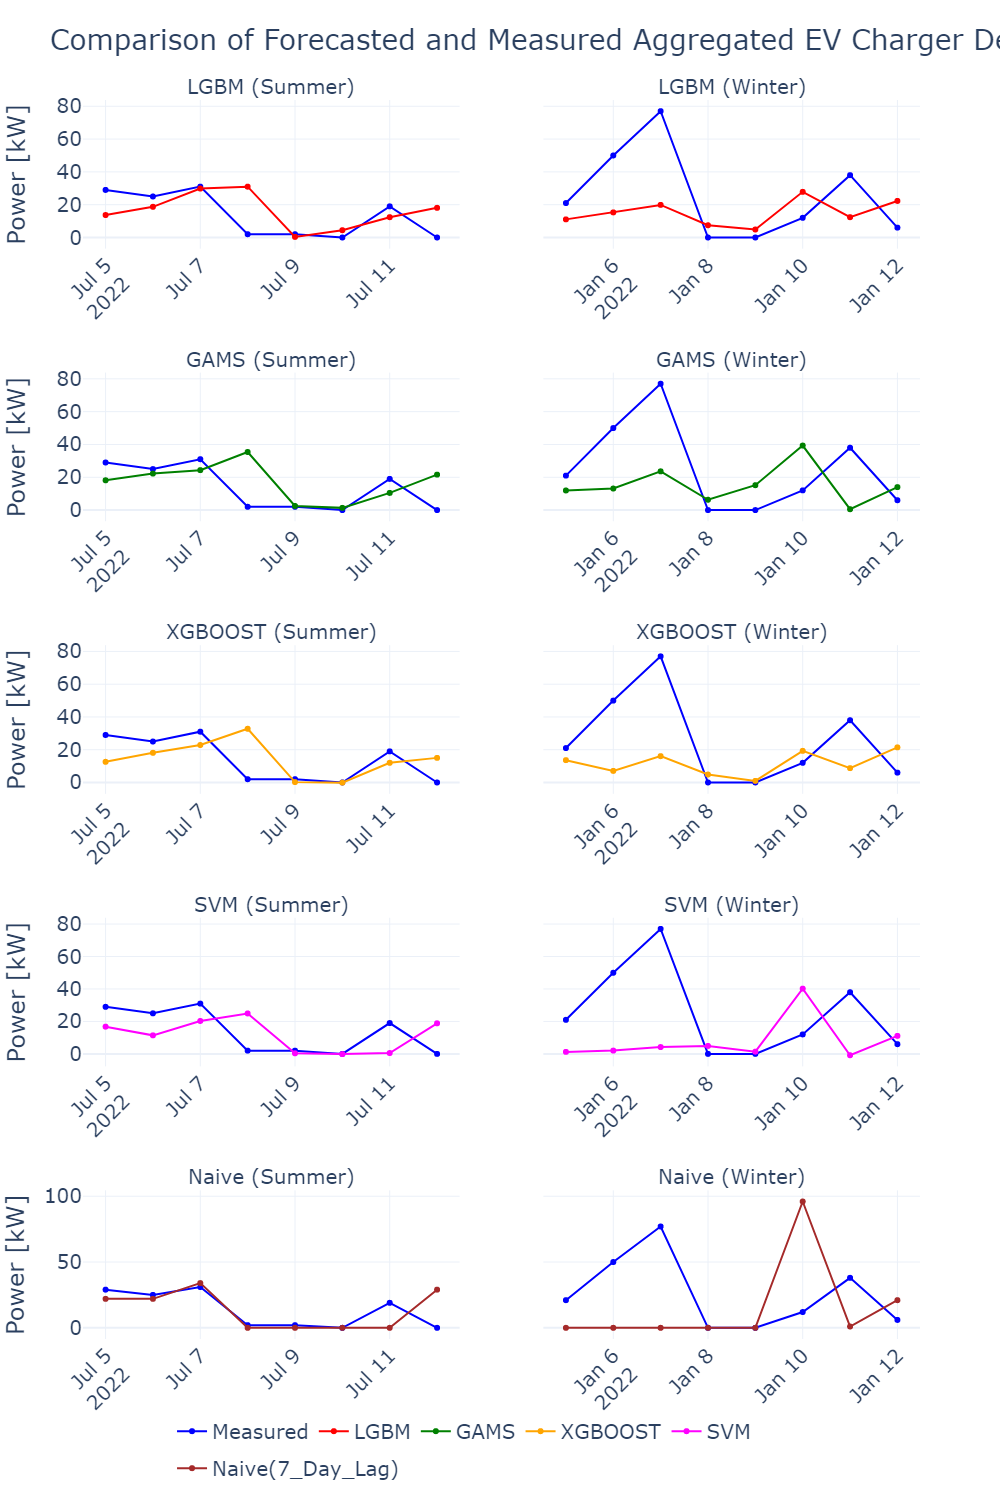

In [38]:

w , h = 1200, 1500
layout = {
    "title_text"  : 'Comparison of Forecasted and Measured Aggregated EV Charger Demand',
   "font":{"size" : 20}, "template": "plotly_white", "width" : w, "height" : h,
    'xaxis': {"title_text" : "","tickangle" : -45},
    'xaxis2': { "title_text" : "","tickangle" : -45},
    'xaxis3': { "title_text" : "","tickangle" : -45},
    'xaxis4': {"title_text" : "","tickangle" : -45},
    'xaxis5': { "title_text" : "","tickangle" : -45},
    'xaxis6': { "title_text" : "","tickangle" : -45},
    'xaxis7': { "title_text" : "","tickangle" : -45},
    'xaxis8': { "title_text" : "","tickangle" : -45},
    'xaxis9': { "title_text" : "","tickangle" : -45},
    'xaxis10': { "title_text" : "","tickangle" : -45},
    "yaxis": {"title_text" : 'Power [kW]'},
    "yaxis3": {"title_text" : 'Power [kW]'},
    "yaxis5": {"title_text" : 'Power [kW]'},
    "yaxis7": {"title_text" : 'Power [kW]'},
    "yaxis9": {"title_text" : 'Power [kW]'},
    
    
     "legend" : {"tracegroupgap":8 ,"font_size": 20, "orientation":"h", "yanchor":"bottom",
    "y":-0.12,"x":0.120, "title" : ""}
            }




df_ = df_ev_eval.copy().loc["2022-07-05": "2022-07-12"]
# Create subplots with 1 row and 3 columns, sharing the y-axis
fig = sp.make_subplots(rows=5, cols=2, subplot_titles=('LGBM (Summer)','LGBM (Winter)',
                                                        'GAMS (Summer)','GAMS (Winter)',
                                                       'XGBOOST (Summer)','XGBOOST (Winter)',
                                                       'SVM (Summer)', 'SVM (Winter)',
                                                       "Naive (Summer)", "Naive (Winter)"),shared_yaxes=True)

# Add the measured column to each subplot
col = 1
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=True,
                         line_color='blue'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=5, col=col)


# Add the remaining columns to each subplot
fig.add_trace(go.Scatter(x=df_.index, y=df_['LGBM'], name='LGBM',line_color='red'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['GAMS'], name='GAMS',line_color='green'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['XGBOOST'], name='XGBOOST',line_color='orange'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['SVM'], name='SVM',line_color='magenta',showlegend=True,), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Naive'], name='Naive(7_Day_Lag)',line_color='brown',
                         showlegend=True,), row=5, col=col)


df_ = df_ev_eval.copy().loc["2022-01-05": "2022-01-12"]
col = 2
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Measured'], name='Measured', legendgroup='Measured', showlegend=False,
                         line_color='blue'), row=5, col=col)


fig.add_trace(go.Scatter(x=df_.index, y=df_['LGBM'], name='LGBM',line_color='red', showlegend=False), row=1, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['GAMS'], name='GAMS',line_color='green', showlegend=False), row=2, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['XGBOOST'], name='XGBOOST',line_color='orange', showlegend=False), row=3, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['SVM'], name='SVM',line_color='magenta', showlegend=False), row=4, col=col)
fig.add_trace(go.Scatter(x=df_.index, y=df_['Naive'], name='Naive(7_Day_Lag)',line_color='brown', showlegend=False), row=5, col=col)

fig.update_layout(layout)


# fig.update_xaxes(matches='x')
# fig.update_yaxes(matches='y')
fig.update_annotations(font_size=20)
fig.update_layout(legend=dict(orientation="h"))

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

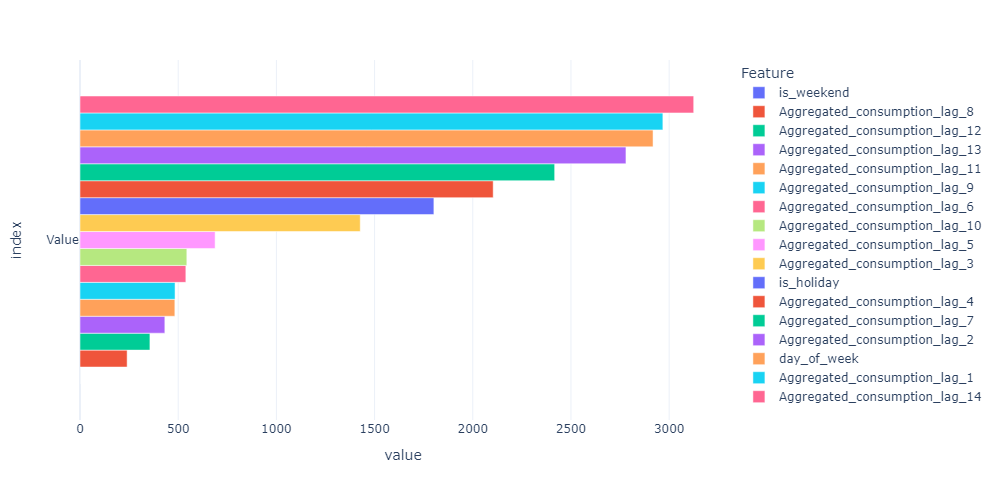

In [39]:
feature_imp = pd.DataFrame(sorted(zip(model_ev_lgbm.feature_importances_,x_test.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.set_index("Feature").T
fig = px.bar(feature_imp,barmode = "group", orientation = "h",template = "plotly_white")

if show_plots:

    fig.show("png",width = 1000)
    
else:
    fig.show()

### Evaluation of predictions

In [40]:
metric_list = ["r2_score", "mean_absolute_error","mean_squared_error",]

period = 1
df_evals_1 = df_ev_eval.copy().interpolate()
df_evals_1 = df_evals_1.iloc[24:]
cols = ["XGBOOST","LGBM","GAMS","Naive","SVM"]
for col in cols:
    
    for metric in metric_list:
        print (metric)
        df_evals_1 = prediction_error(df=df_evals_1, metric = metric , period =period, predict = col ,perfect = "Measured")
        
cols = [col for col in df_evals_1.columns if "MSE" in col or "MAE" in col or "R²" in col]
# print (cols)
df_evals_1[cols].resample("1D").mean().describe().T[["min","max"]].sort_index()

r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error


min          max
MAE_[GAMS]     2.099770e-01    73.254065
MAE_[LGBM]     8.876969e-04    73.421474
MAE_[Naive]    0.000000e+00    94.992237
MAE_[SVM]      1.840178e-03    81.029794
MAE_[XGBOOST]  2.273493e-02    76.205192
MSE_[GAMS]     4.409034e-02  5366.158084
MSE_[LGBM]     7.880058e-07  5390.712915
MSE_[Naive]    0.000000e+00  9023.525120
MSE_[SVM]      3.386255e-06  6565.827441
MSE_[XGBOOST]  5.168768e-04  5807.231358
R²_[GAMS]               NaN          NaN
R²_[LGBM]               NaN          NaN
R²_[Naive]              NaN          NaN
R²_[SVM]                NaN          NaN
R²_[XGBOOST]            NaN          NaN

In [41]:
metric_list = ["r2_score", "mean_absolute_error","mean_squared_error",]

period = 365
df_evals_1 = df_ev_eval.copy().interpolate()
df_evals_1 = df_evals_1.iloc[24:]
cols = ["XGBOOST","LGBM","GAMS","Naive", "SVM"]
for col in cols:
    
    for metric in metric_list:
        print (metric)
        df_evals_1 = prediction_error(df=df_evals_1, metric = metric , period =period, predict = col ,perfect = "Measured")
        
cols = [col for col in df_evals_1.columns if "MSE" in col or "MAE" in col or "R²" in col]
# print (cols)
df_evals_1[cols].resample("1D").mean().describe().T[["min","max"]].sort_index()

r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error
r2_score
mean_absolute_error
mean_squared_error


min         max
MAE_[GAMS]      13.591872   13.591872
MAE_[LGBM]      12.918907   12.918907
MAE_[Naive]     15.139893   15.139893
MAE_[SVM]       12.555325   12.555325
MAE_[XGBOOST]   11.878456   11.878456
MSE_[GAMS]     365.742057  365.742057
MSE_[LGBM]     328.691300  328.691300
MSE_[Naive]    601.338387  601.338387
MSE_[SVM]      395.031531  395.031531
MSE_[XGBOOST]  328.211943  328.211943
R²_[GAMS]        0.147718    0.147718
R²_[LGBM]        0.234057    0.234057
R²_[Naive]      -0.401288   -0.401288
R²_[SVM]         0.079465    0.079465
R²_[XGBOOST]     0.235174    0.235174

### Comment 
None of the forecasting approaches performed particularly well, however, given the sparse nature of the data and the high degree of randomness in the data. This problem was not a result of the ML methods, but rather the data itself. As already indicated, the data was sparse and very random in nature. Both issues are the result of a low number of EV users relative to the number of available charging stations, and the data's predictability is expected to improve as the number of EV users increases. Additionally, data augmentation methods can be applied to the data as a means to improve the predictability of the data, this is however not covered in the scope of this thesis. 
